In [2]:
# General Libraries
import re
import gc
import os
import cv2
import copy
import math
import shutil
from tqdm import tqdm
from time import time
import datetime as dtime
from pprint import pprint
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Get image path
base_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/"
''
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train["path"] = all_paths

display(train.head())

100%|██████████| 54706/54706 [00:05<00:00, 9343.66it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


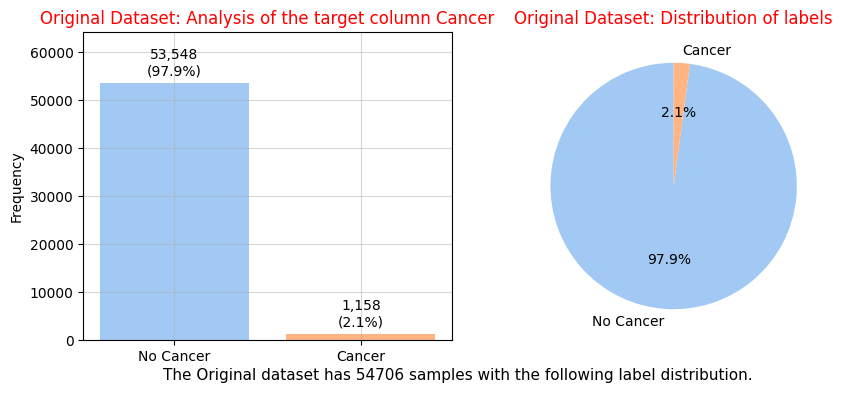

In [68]:
plot_label_distribution(cleaned_data,'Original')

---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 43764
Test data size: 10942


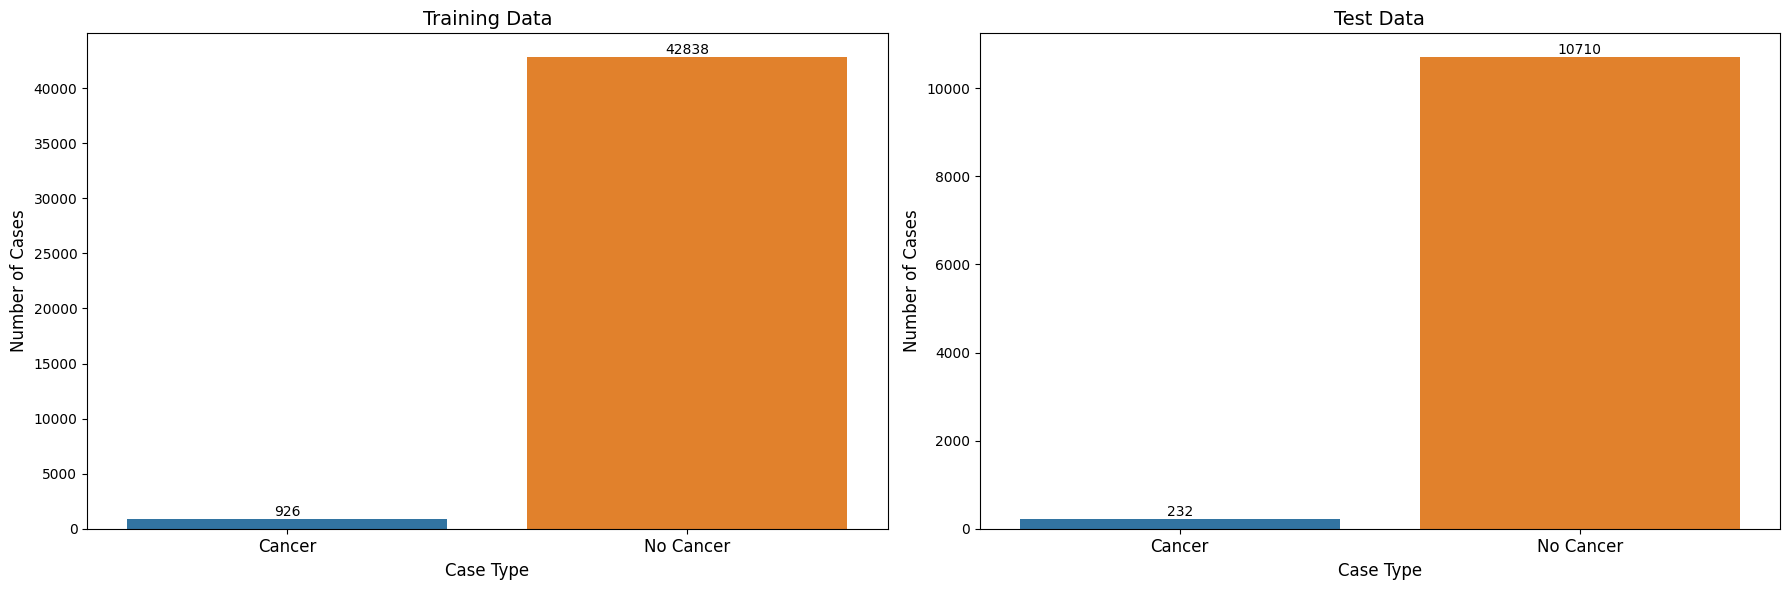

---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


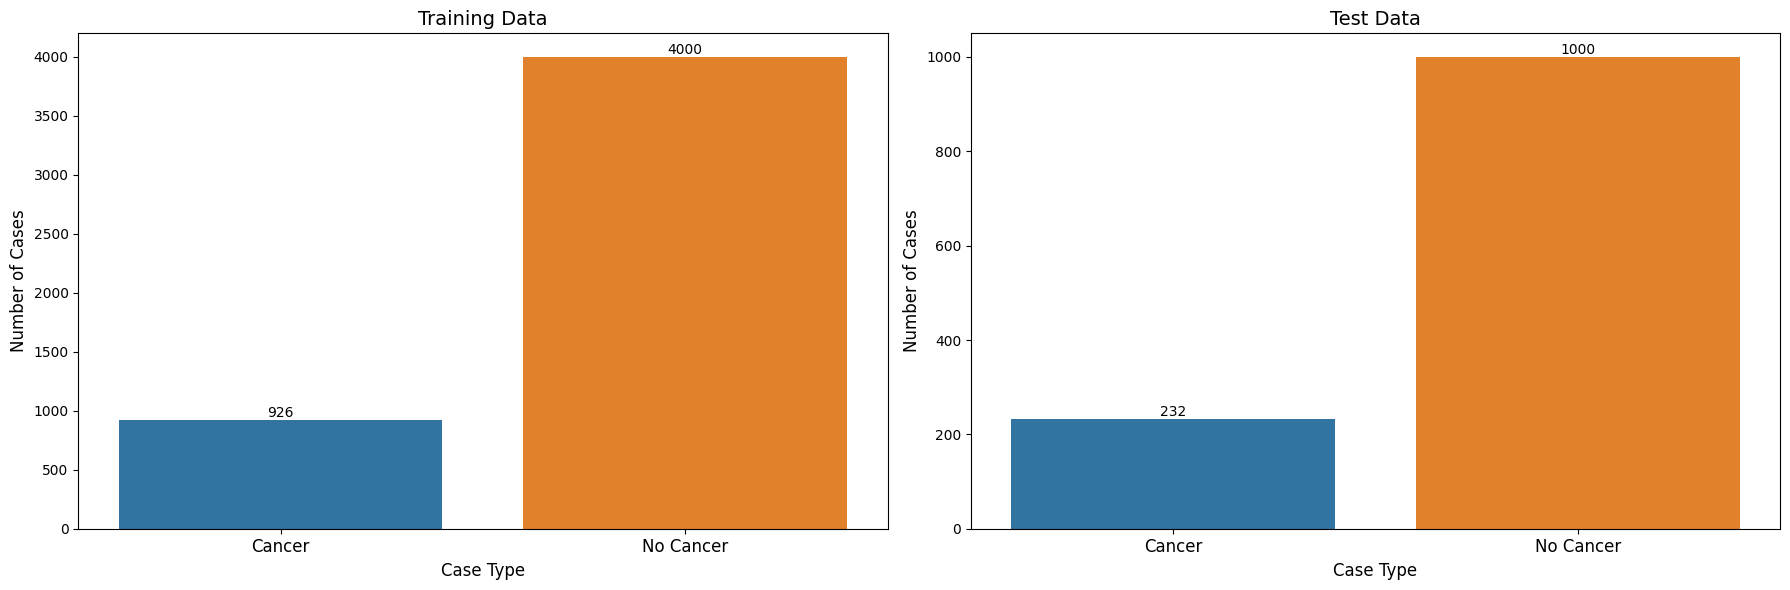

In [71]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 1
train_data, test_data = split_dataset_model_1(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [76]:
# ----- GLOBAL PARAMS ------
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# --------------------------
# Use the set_seed function to initialize the seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cuda


In [77]:
# Sample data
sample = train_data.head(10) #train_data, test_data

# Instantiate Dataset object
dataset = My_Custom_RSNA_Dataset(sample,csv_columns) #CustomRSNADataset(sample,csv_columns,is_train=True)

# The Dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=False,num_workers=4)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(Color.S + f"Batch: {k}" + Color.E, "\n" + Color.S + "Image:" + Color.E, image.shape, "\n" + Color.S + "Meta:" + Color.E, meta, "\n" + Color.S + "Targets:" + Color.E, targets, "\n" + "="*50)

Batch: 0 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 50.,  0.],
        [ 0.,  5., 66.,  0.],
        [ 1.,  1., 51.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 1.,  1., 48.,  0.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 
Batch: 1 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 65.,  0.],
        [ 1.,  5., 40.,  0.],
        [ 0.,  5., 53.,  0.],
        [ 0.,  5., 56.,  0.],
        [ 0.,  1., 65.,  0.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 


In [78]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(1,1), gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, preds, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.flatten(preds), torch.flatten(targets).float())
        logits=nn.Sigmoid()(preds)
        F_loss = (self.alpha[0]*(targets)*((1-logits)**self.gamma)+ self.alpha[1]*(1-targets)*((logits)**self.gamma)) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [79]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [80]:
# Load Model
EffNetNet_model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = EffNetNet_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example =FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Loaded pretrained weights for efficientnet-b2
Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1408])
Meta Data: torch.Size([5, 250])
Concatenated Data: torch.Size([5, 1658])
Out shape: torch.Size([5, 1])
Loss: 0.10861670970916748


In [94]:
def Train_Model_Applying_k_Fold_Cross_Validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = My_Custom_RSNA_Dataset(train_data, csv_columns) #CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = My_Custom_RSNA_Dataset(valid_data, csv_columns) #CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []
        
        # Initialisation du modèle
        # model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié


        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            # scheduler.step(val_loss)
            scheduler.step(val_f1) 

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }

        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

        
    # === CLEANING ===
    # Clear memory
    del train_loader, valid_loader, train,  valid, images, meta, labels
    gc.collect()    
        
    # Close log file
    close_file(log_file_path)

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 618, Validation instances - 308
Class No Cancer: Training instances - 28558, Validation instances - 14280
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.8, loss=0.00109]


Training metrics for Epoch 1:
Accuracy: 0.9775843158760625
ROC: 0.5009528102803787
Precision: 0.05
Recall: 0.003236245954692557
F1 score: 0.006079027355623101
Train loss: 0.0011
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:29<00:00,  4.91batch/s, accuracy=97.9, loss=0.000991]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Validation metrics for Epoch 1:
Accuracy: 0.9788867562380038
ROC: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.49      0.50      0.49     14588
weighted avg       0.96      0.98      0.97     14588



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


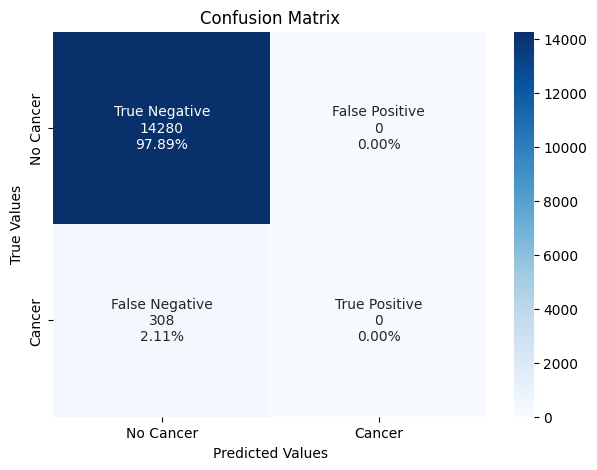

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000974]


Training metrics for Epoch 2:
Accuracy: 0.9787839319989032
ROC: 0.4999824917711324
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Train loss: 0.0010
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:29<00:00,  4.99batch/s, accuracy=97.9, loss=0.000974]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Validation metrics for Epoch 2:
Accuracy: 0.9788867562380038
ROC: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.49      0.50      0.49     14588
weighted avg       0.96      0.98      0.97     14588



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


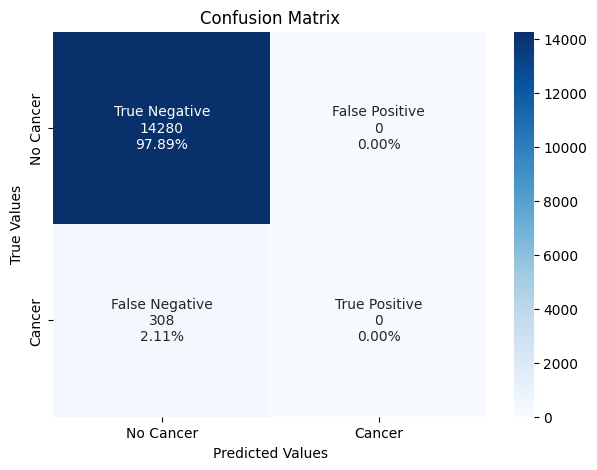

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000927]


Training metrics for Epoch 3:
Accuracy: 0.9788182067452701
ROC: 0.5071239793382502
Precision: 0.5
Recall: 0.014563106796116505
F1 score: 0.02830188679245283
Train loss: 0.0009
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:29<00:00,  4.95batch/s, accuracy=95.5, loss=0.00161]


Validation metrics for Epoch 3:
Accuracy: 0.9546887853029887
ROC: 0.5559396485867074
Precision: 0.0979498861047836
Recall: 0.1396103896103896
F1 score: 0.11512717536813923
Validation Loss: 0.0016
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.10      0.14      0.12       308
   No Cancer       0.98      0.97      0.98     14280

    accuracy                           0.95     14588
   macro avg       0.54      0.56      0.55     14588
weighted avg       0.96      0.95      0.96     14588



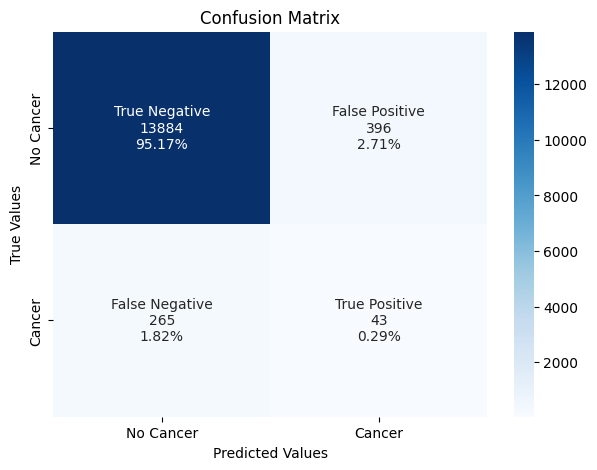

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=97.9, loss=0.000894]


Training metrics for Epoch 4:
Accuracy: 0.9791952289553058
ROC: 0.5199814220126825
Precision: 0.6410256410256411
Recall: 0.040453074433656956
F1 score: 0.076103500761035
Train loss: 0.0009
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:29<00:00,  4.98batch/s, accuracy=97.9, loss=0.001]   


Validation metrics for Epoch 4:
Accuracy: 0.9788182067452701
ROC: 0.5063184364654952
Precision: 0.4444444444444444
Recall: 0.012987012987012988
F1 score: 0.02523659305993691
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.44      0.01      0.03       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.71      0.51      0.51     14588
weighted avg       0.97      0.98      0.97     14588



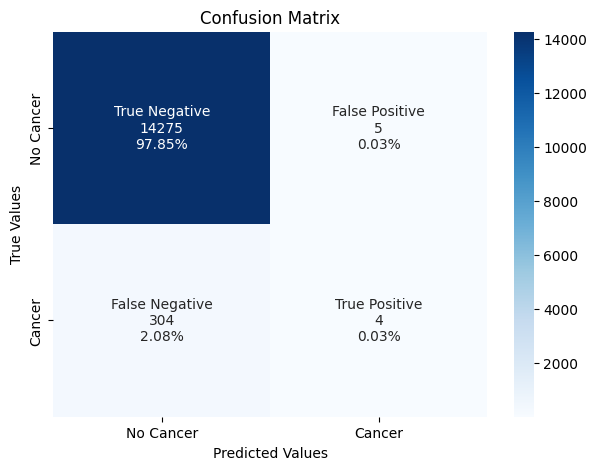

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98, loss=0.000783]  


Training metrics for Epoch 5:
Accuracy: 0.980223471346312
ROC: 0.5648336514278215
Precision: 0.6694214876033058
Recall: 0.13106796116504854
F1 score: 0.2192151556156969
Train loss: 0.0008
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:29<00:00,  4.96batch/s, accuracy=97.8, loss=0.00104]


Validation metrics for Epoch 5:
Accuracy: 0.9779270633397313
ROC: 0.5106283422459893
Precision: 0.25
Recall: 0.022727272727272728
F1 score: 0.04166666666666667
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.25      0.02      0.04       308
   No Cancer       0.98      1.00      0.99     14280

    accuracy                           0.98     14588
   macro avg       0.61      0.51      0.52     14588
weighted avg       0.96      0.98      0.97     14588



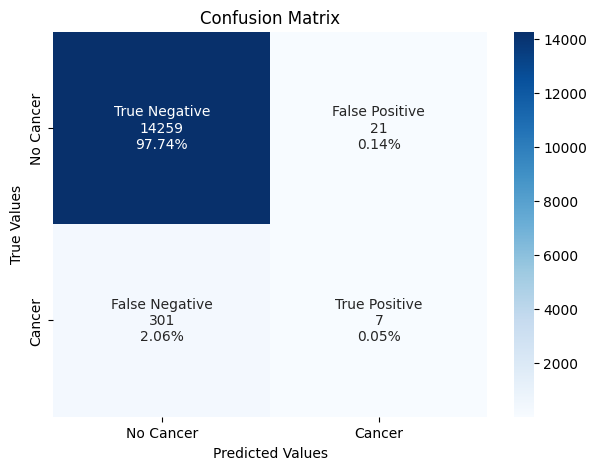

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Finished Training


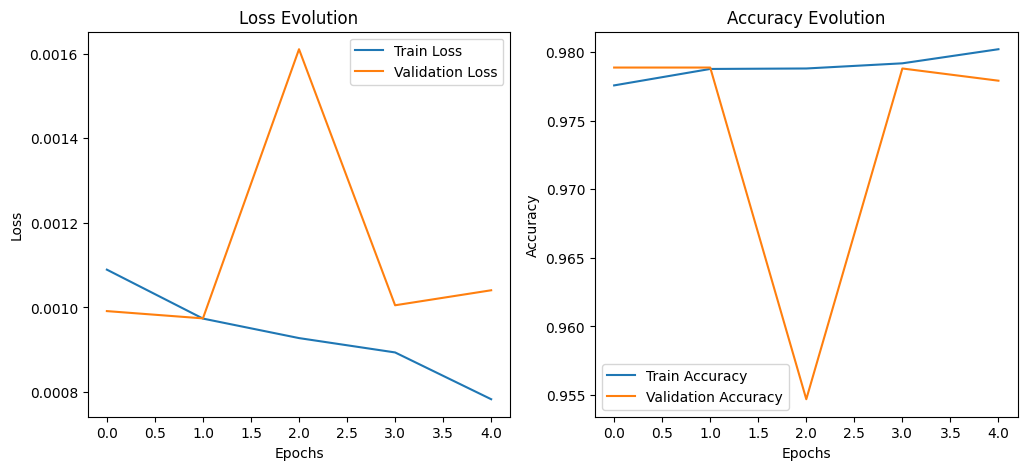

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.9779 Precision: 0.2500 Recall: 0.0227 F1: 0.1151 ROC: 0.5106
---------- Fold: 2 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 28559, Validation instances - 14279
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.2, loss=0.000777]


Training metrics for Epoch 1:
Accuracy: 0.9815259117082533
ROC: 0.5877878960005625
Precision: 0.7785714285714286
Recall: 0.1766612641815235
F1 score: 0.28797886393659183
Train loss: 0.0008
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:29<00:00,  4.93batch/s, accuracy=98.6, loss=0.000504]


Validation metrics for Epoch 1:
Accuracy: 0.986358650945983
ROC: 0.681159740547313
Precision: 0.9824561403508771
Recall: 0.36245954692556637
F1 score: 0.5295508274231678
Validation Loss: 0.0005
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.36      0.53       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.98      0.68      0.76     14588
weighted avg       0.99      0.99      0.98     14588



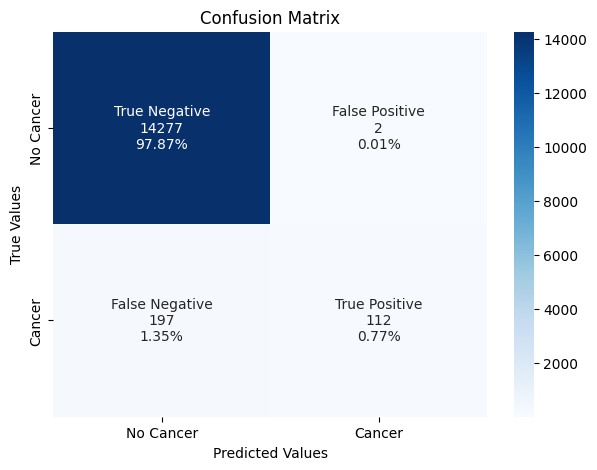

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.3, loss=0.000696]


Training metrics for Epoch 2:
Accuracy: 0.9831368247874965
ROC: 0.6227039556372337
Precision: 0.8491620111731844
Recall: 0.24635332252836303
F1 score: 0.3819095477386935
Train loss: 0.0007
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:28<00:00,  5.08batch/s, accuracy=98.8, loss=0.000452]


Validation metrics for Epoch 2:
Accuracy: 0.9880723882643269
ROC: 0.7200297084613587
Precision: 0.9927007299270073
Recall: 0.4401294498381877
F1 score: 0.6098654708520179
Validation Loss: 0.0005
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.44      0.61       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.99      0.72      0.80     14588
weighted avg       0.99      0.99      0.99     14588



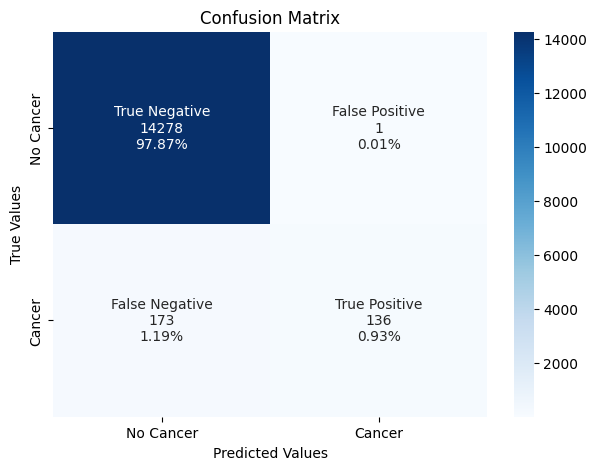

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.6, loss=0.000593]


Training metrics for Epoch 3:
Accuracy: 0.9857417055113792
ROC: 0.6803279604910145
Precision: 0.9102040816326531
Recall: 0.36142625607779577
F1 score: 0.5174013921113688
Train loss: 0.0006
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:28<00:00,  5.07batch/s, accuracy=99, loss=0.000403] 


Validation metrics for Epoch 3:
Accuracy: 0.9897861255826707
ROC: 0.7683983154930715
Precision: 0.9651162790697675
Recall: 0.5372168284789643
F1 score: 0.6902286902286902
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.54      0.69       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.98      0.77      0.84     14588
weighted avg       0.99      0.99      0.99     14588



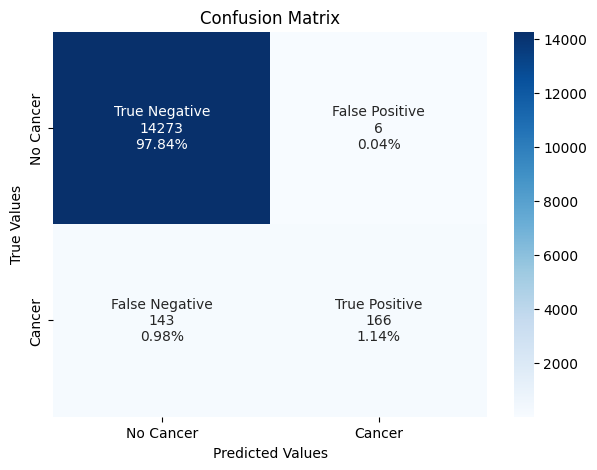

Current Learning Rate: 0.0001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.8, loss=0.000477]


Training metrics for Epoch 4:
Accuracy: 0.9879695640252262
ROC: 0.7417237073491636
Precision: 0.9006024096385542
Recall: 0.4846029173419773
F1 score: 0.6301369863013698
Train loss: 0.0005
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:29<00:00,  5.02batch/s, accuracy=99, loss=0.000394] 


Validation metrics for Epoch 4:
Accuracy: 0.9896490265972032
ROC: 0.7952410934109905
Precision: 0.8798076923076923
Recall: 0.5922330097087378
F1 score: 0.7079303675048355
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.59      0.71       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.94      0.80      0.85     14588
weighted avg       0.99      0.99      0.99     14588



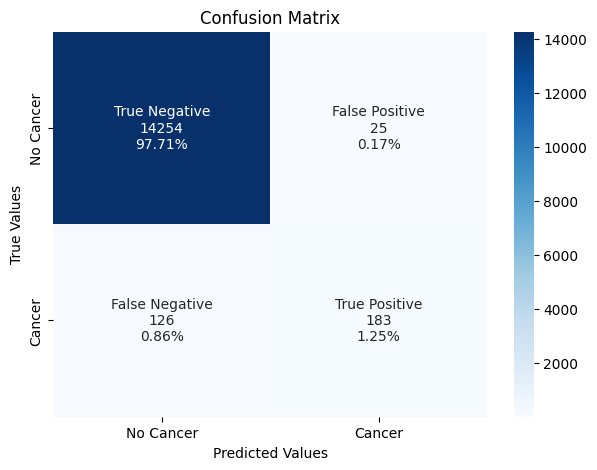

Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99, loss=0.000374]  


Training metrics for Epoch 5:
Accuracy: 0.9904030710172744
ROC: 0.804810230213514
Precision: 0.9040767386091128
Recall: 0.6110210696920584
F1 score: 0.7292069632495164
Train loss: 0.0004
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:28<00:00,  5.10batch/s, accuracy=98.9, loss=0.000426]


Validation metrics for Epoch 5:
Accuracy: 0.9892377296408007
ROC: 0.776033716429246
Precision: 0.9
Recall: 0.5533980582524272
F1 score: 0.6853707414829658
Validation Loss: 0.0004
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.55      0.69       309
   No Cancer       0.99      1.00      0.99     14279

    accuracy                           0.99     14588
   macro avg       0.95      0.78      0.84     14588
weighted avg       0.99      0.99      0.99     14588



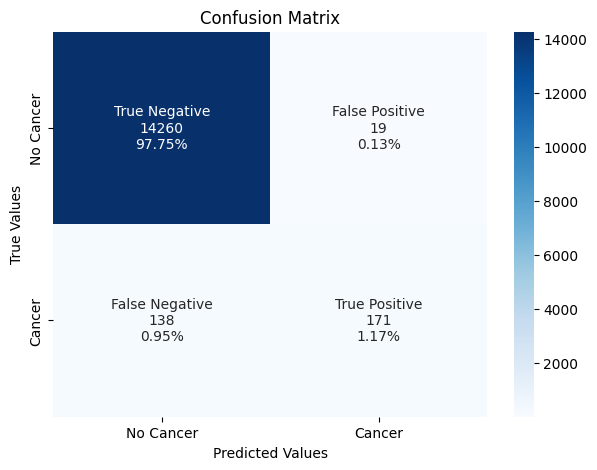

Current Learning Rate: 0.0001
Finished Training


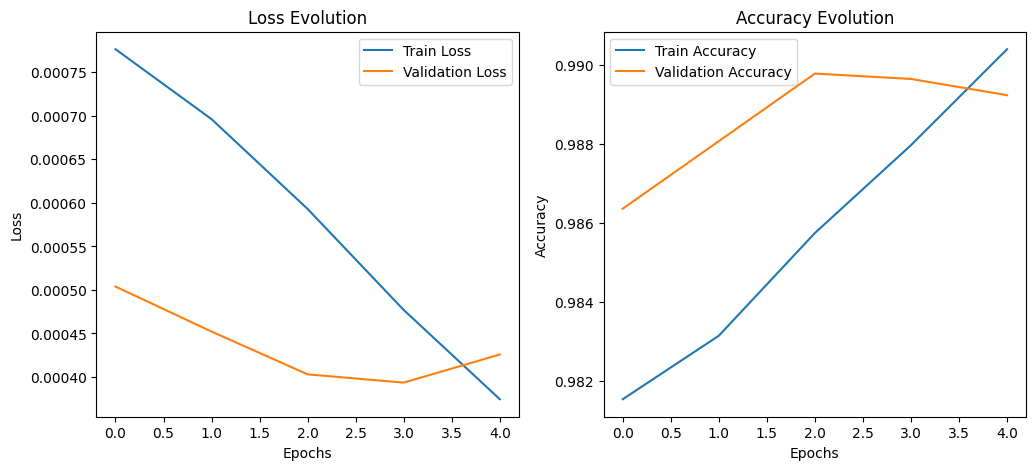

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9892 Precision: 0.9000 Recall: 0.5534 F1: 0.7079 ROC: 0.7760
---------- Fold: 3 ----------
Dimensions of train_data: (29176, 9)
Dimensions of valid_data: (14588, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 28559, Validation instances - 14279
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=98.9, loss=0.000428]


Training metrics for Epoch 1:
Accuracy: 0.9885179599670962
ROC: 0.7745113005843117
Precision: 0.8542713567839196
Recall: 0.5510534846029174
F1 score: 0.6699507389162562
Train loss: 0.0004
Validating the trained model's performance


Validation 1: 100%|██████████| 146/146 [00:28<00:00,  5.10batch/s, accuracy=99.9, loss=0.000102]


Validation metrics for Epoch 1:
Accuracy: 0.9985604606525912
ROC: 0.9660194174757282
Precision: 1.0
Recall: 0.9320388349514563
F1 score: 0.9648241206030151
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.93      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       1.00      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



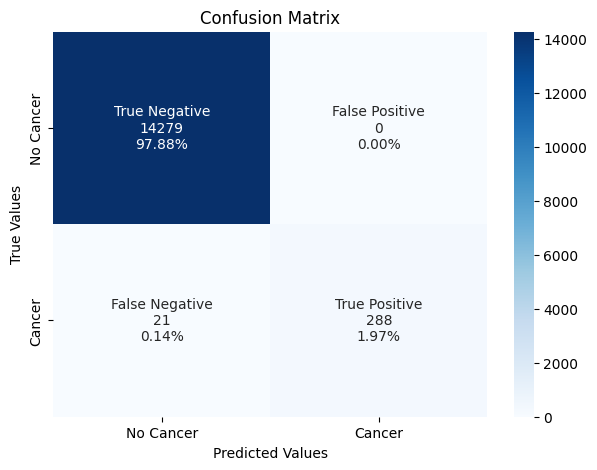

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.2, loss=0.000313]


Training metrics for Epoch 2:
Accuracy: 0.9920139840965176
ROC: 0.8365548292275373
Precision: 0.9285714285714286
Recall: 0.6742301458670988
F1 score: 0.7812206572769953
Train loss: 0.0003
Validating the trained model's performance


Validation 2: 100%|██████████| 146/146 [00:28<00:00,  5.13batch/s, accuracy=99.9, loss=8.44e-5]


Validation metrics for Epoch 2:
Accuracy: 0.9985604606525912
ROC: 0.9660194174757282
Precision: 1.0
Recall: 0.9320388349514563
F1 score: 0.9648241206030151
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.93      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       1.00      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



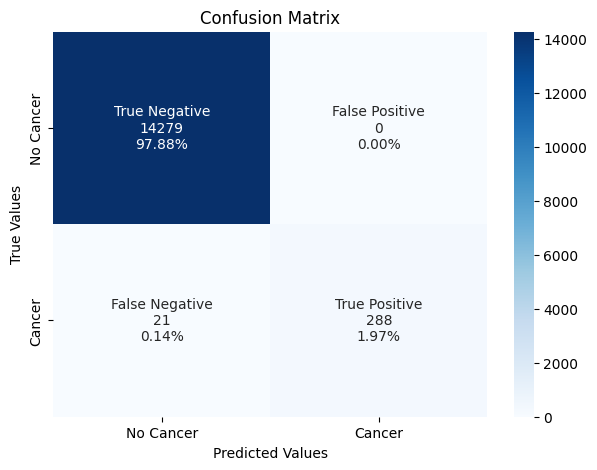

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.5, loss=0.0002]  


Training metrics for Epoch 3:
Accuracy: 0.994995887030436
ROC: 0.8983357436335698
Precision: 0.9590643274853801
Recall: 0.7974068071312804
F1 score: 0.8707964601769912
Train loss: 0.0002
Validating the trained model's performance


Validation 3: 100%|██████████| 146/146 [00:28<00:00,  5.11batch/s, accuracy=99.9, loss=7.18e-5]


Validation metrics for Epoch 3:
Accuracy: 0.9985604606525912
ROC: 0.9707687370345617
Precision: 0.9897959183673469
Recall: 0.941747572815534
F1 score: 0.9651741293532338
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.94      0.97       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.99      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



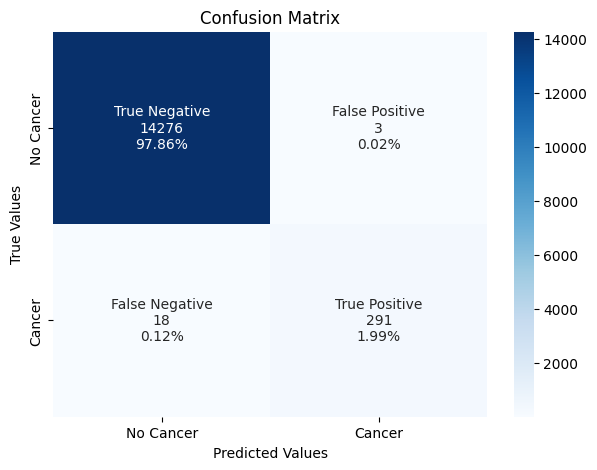

Current Learning Rate: 0.0001
Training the model


Epoch 4, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.6, loss=0.000162]


Training metrics for Epoch 4:
Accuracy: 0.9956813819577736
ROC: 0.9145431990630674
Precision: 0.9606003752345216
Recall: 0.8298217179902755
F1 score: 0.8904347826086956
Train loss: 0.0002
Validating the trained model's performance


Validation 4: 100%|██████████| 146/146 [00:30<00:00,  4.83batch/s, accuracy=99.8, loss=8.73e-5]


Validation metrics for Epoch 4:
Accuracy: 0.9981491636961887
ROC: 0.9705586382881509
Precision: 0.97
Recall: 0.941747572815534
F1 score: 0.9556650246305418
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.94      0.96       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.98      0.97      0.98     14588
weighted avg       1.00      1.00      1.00     14588



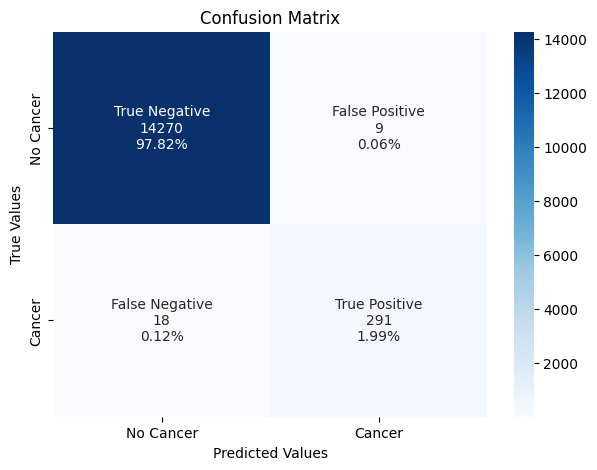

Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 292/292 [03:09<00:00,  1.54batch/s, accuracy=99.7, loss=0.000112]


Training metrics for Epoch 5:
Accuracy: 0.9967781738415136
ROC: 0.9404751277502634
Precision: 0.9628318584070796
Recall: 0.8816855753646677
F1 score: 0.9204737732656514
Train loss: 0.0001
Validating the trained model's performance


Validation 5: 100%|██████████| 146/146 [00:29<00:00,  5.01batch/s, accuracy=99.8, loss=8.47e-5]


Validation metrics for Epoch 5:
Accuracy: 0.9979435152179874
ROC: 0.9593718432776673
Precision: 0.9826989619377162
Recall: 0.919093851132686
F1 score: 0.9498327759197324
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.92      0.95       309
   No Cancer       1.00      1.00      1.00     14279

    accuracy                           1.00     14588
   macro avg       0.99      0.96      0.97     14588
weighted avg       1.00      1.00      1.00     14588



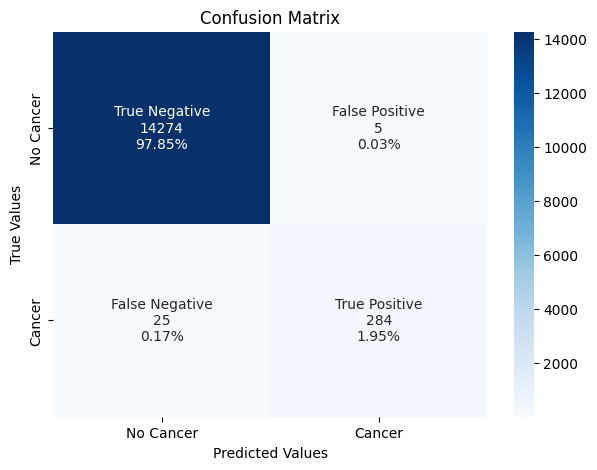

Current Learning Rate: 0.0001
Finished Training


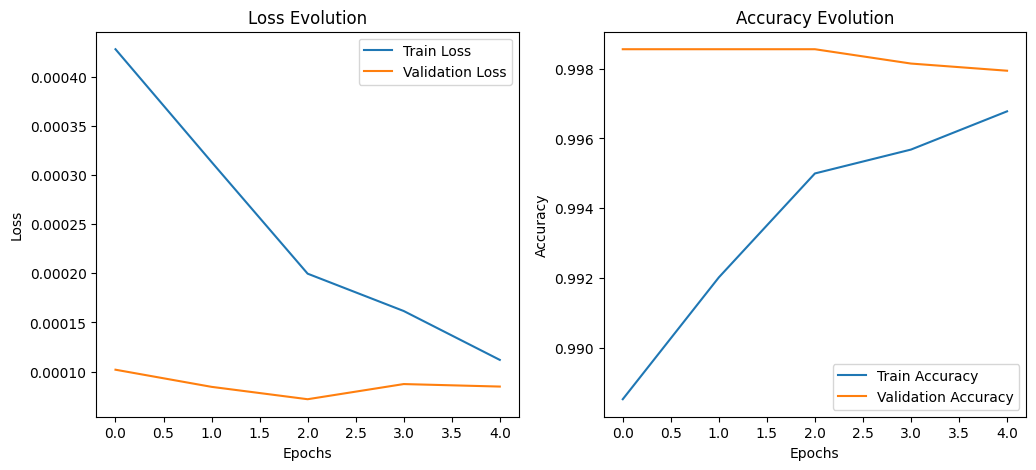

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9979 Precision: 0.9827 Recall: 0.9191 F1: 0.9652 ROC: 0.9594
The overall best model has been saved with metrics - Val Acc: 0.9979, Precision: 0.9827, Recall: 0.9191, F1: 0.9652, ROC: 0.9594
Log file at /kaggle/working/Logs/logs_1.0.0.txt has been closed.


In [34]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 100,  # Taille du batch pour la validation
    "train_batch_size": 100,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '1.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,train_data,hyperparameters)

##### Test The Best Model

Shape Of Train Sample: (10942, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,50251,1764774515,1,1,66.0,0,0,No Cancer,/kaggle/working/Processed Image/50251/17647745...
1,17552,2020448477,0,5,77.0,0,0,No Cancer,/kaggle/working/Processed Image/17552/20204484...
2,56125,569514262,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/56125/56951426...
3,59102,1324423486,0,1,46.0,0,0,No Cancer,/kaggle/working/Processed Image/59102/13244234...
4,7420,331414632,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/7420/331414632...


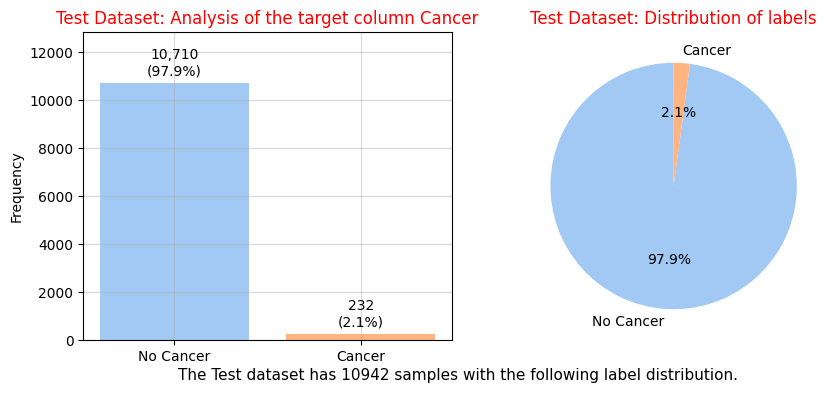

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 365/365 [00:22<00:00, 16.25batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.23      0.03      0.06       232
   No Cancer       0.98      1.00      0.99     10710

    accuracy                           0.98     10942
   macro avg       0.60      0.52      0.52     10942
weighted avg       0.96      0.98      0.97     10942



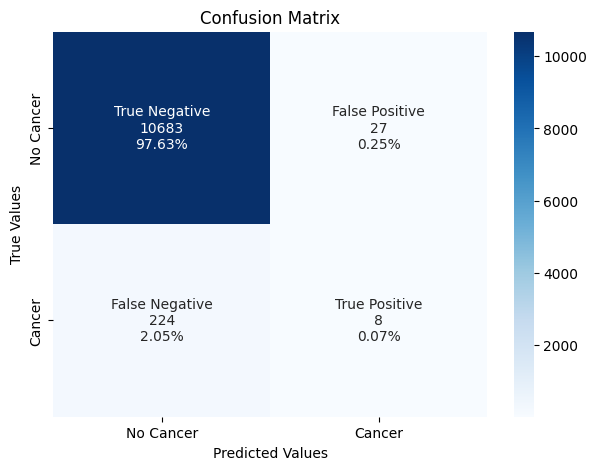

In [35]:
print(f'Shape Of Train Sample: {test_data.shape}')
display(test_data.head())
print("======="*25)
plot_label_distribution(test_data,'Test')
print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3
data_test = test_data.copy()
data_test = test_data.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(data_test,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


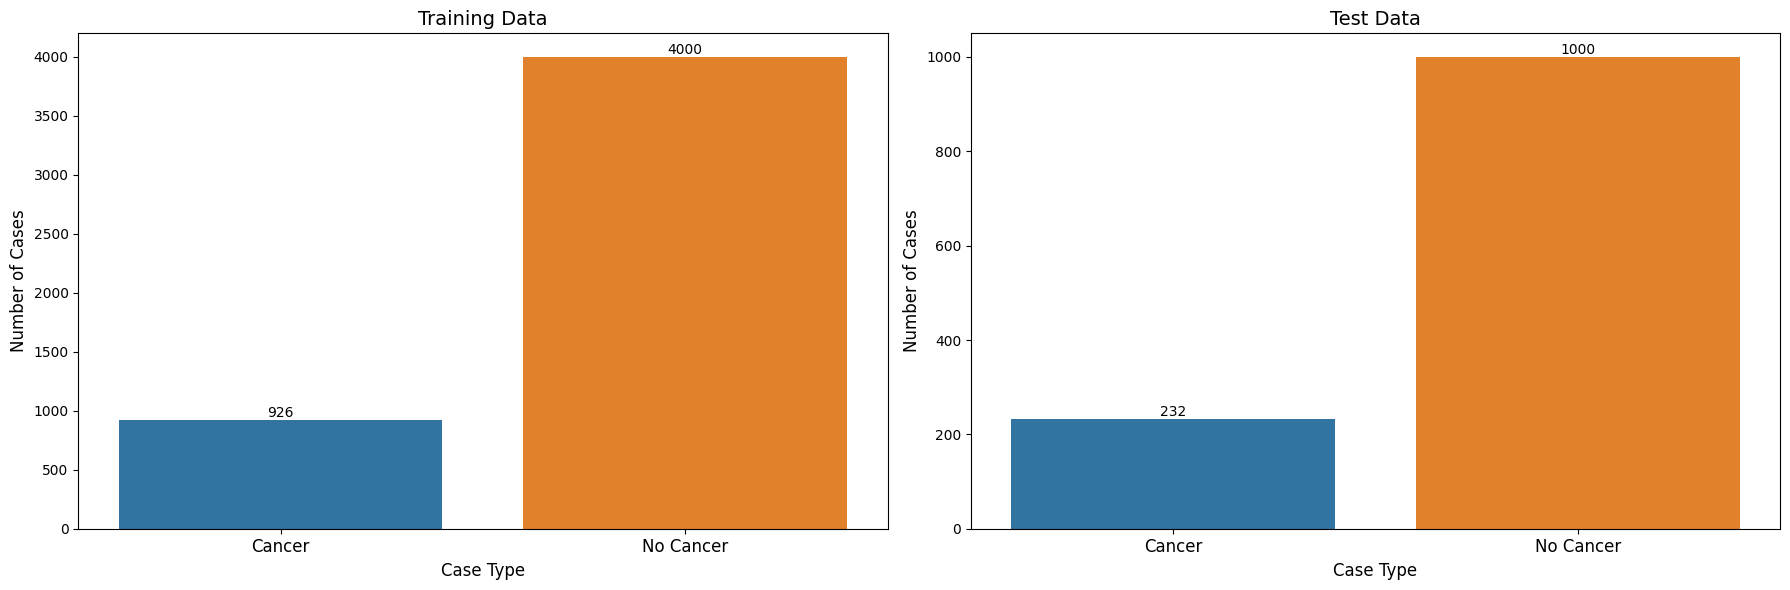

In [41]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 618, Validation instances - 308
Class No Cancer: Training instances - 2666, Validation instances - 1334
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=80, loss=0.00489]  


Training metrics for Epoch 1:
Accuracy: 0.7999390986601705
ROC: 0.5250044307193305
Precision: 0.36363636363636365
Recall: 0.08414239482200647
F1 score: 0.1366622864651774
Train loss: 0.0049
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.74batch/s, accuracy=77, loss=0.00537]  


Validation metrics for Epoch 1:
Accuracy: 0.7704019488428745
ROC: 0.5690287972896668
Precision: 0.3438914027149321
Recall: 0.24675324675324675
F1 score: 0.28733459357277885
Validation Loss: 0.0054
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.34      0.25      0.29       308
   No Cancer       0.84      0.89      0.86      1334

    accuracy                           0.77      1642
   macro avg       0.59      0.57      0.58      1642
weighted avg       0.74      0.77      0.76      1642



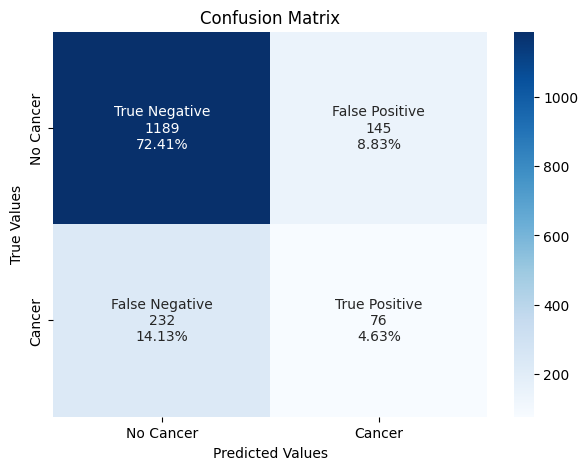

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=83, loss=0.00404]  


Training metrics for Epoch 2:
Accuracy: 0.8297807551766139
ROC: 0.603049427405395
Precision: 0.6244725738396625
Recall: 0.23948220064724918
F1 score: 0.34619883040935673
Train loss: 0.0040
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.79batch/s, accuracy=81.4, loss=0.00603]


Validation metrics for Epoch 2:
Accuracy: 0.8136419001218027
ROC: 0.5069924453357736
Precision: 0.625
Recall: 0.016233766233766232
F1 score: 0.03164556962025316
Validation Loss: 0.0060
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.62      0.02      0.03       308
   No Cancer       0.81      1.00      0.90      1334

    accuracy                           0.81      1642
   macro avg       0.72      0.51      0.46      1642
weighted avg       0.78      0.81      0.73      1642



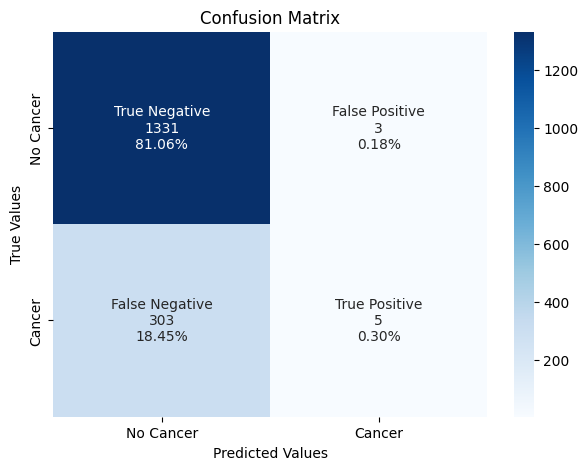

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=87.5, loss=0.00293]


Training metrics for Epoch 3:
Accuracy: 0.8754567600487211
ROC: 0.7213010776966087
Precision: 0.7771883289124668
Recall: 0.4741100323624595
F1 score: 0.5889447236180905
Train loss: 0.0029
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.69batch/s, accuracy=81.9, loss=0.0109]


Validation metrics for Epoch 3:
Accuracy: 0.8191230207064556
ROC: 0.5453255515099593
Precision: 0.6
Recall: 0.10714285714285714
F1 score: 0.18181818181818182
Validation Loss: 0.0109
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.60      0.11      0.18       308
   No Cancer       0.83      0.98      0.90      1334

    accuracy                           0.82      1642
   macro avg       0.71      0.55      0.54      1642
weighted avg       0.78      0.82      0.76      1642



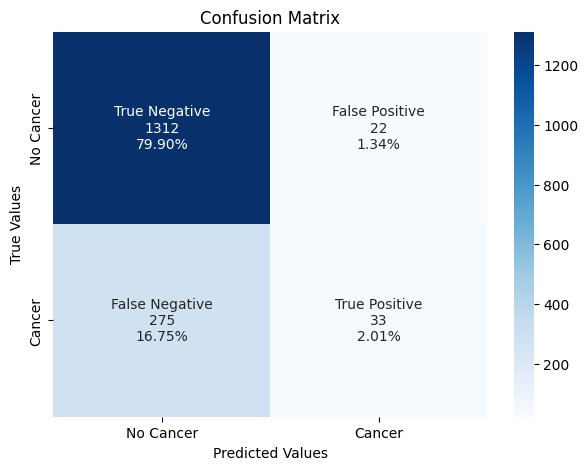

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=92.2, loss=0.00202]


Training metrics for Epoch 4:
Accuracy: 0.9220462850182704
ROC: 0.8494380876772591
Precision: 0.8327205882352942
Recall: 0.7330097087378641
F1 score: 0.7796901893287436
Train loss: 0.0020
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.60batch/s, accuracy=79.2, loss=0.00995]


Validation metrics for Epoch 4:
Accuracy: 0.7917174177831913
ROC: 0.5958814423956853
Precision: 0.4182692307692308
Recall: 0.2824675324675325
F1 score: 0.33720930232558144
Validation Loss: 0.0099
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.42      0.28      0.34       308
   No Cancer       0.85      0.91      0.88      1334

    accuracy                           0.79      1642
   macro avg       0.63      0.60      0.61      1642
weighted avg       0.77      0.79      0.78      1642



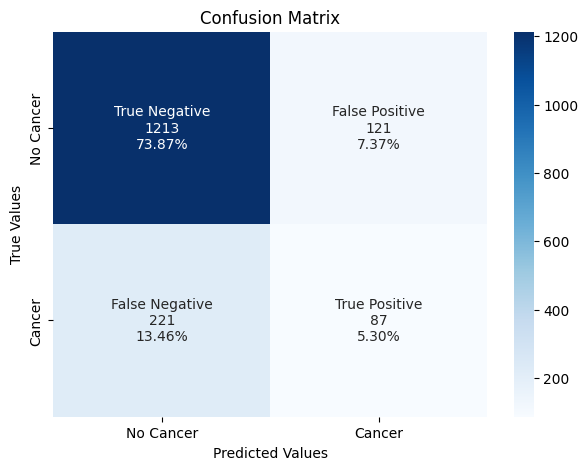

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=95.5, loss=0.00131]


Training metrics for Epoch 5:
Accuracy: 0.9546285018270402
ROC: 0.9186052581106441
Precision: 0.8941176470588236
Recall: 0.86084142394822
F1 score: 0.877164056059357
Train loss: 0.0013
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.87batch/s, accuracy=80.9, loss=0.0191]


Validation metrics for Epoch 5:
Accuracy: 0.8093788063337394
ROC: 0.5131087053875659
Precision: 0.41379310344827586
Recall: 0.03896103896103896
F1 score: 0.0712166172106825
Validation Loss: 0.0191
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.41      0.04      0.07       308
   No Cancer       0.82      0.99      0.89      1334

    accuracy                           0.81      1642
   macro avg       0.62      0.51      0.48      1642
weighted avg       0.74      0.81      0.74      1642



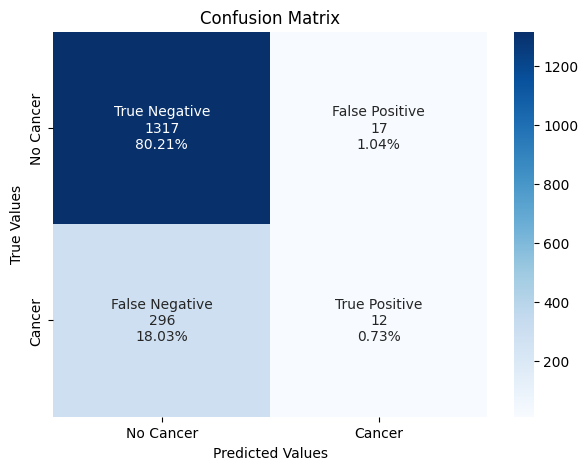

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Finished Training


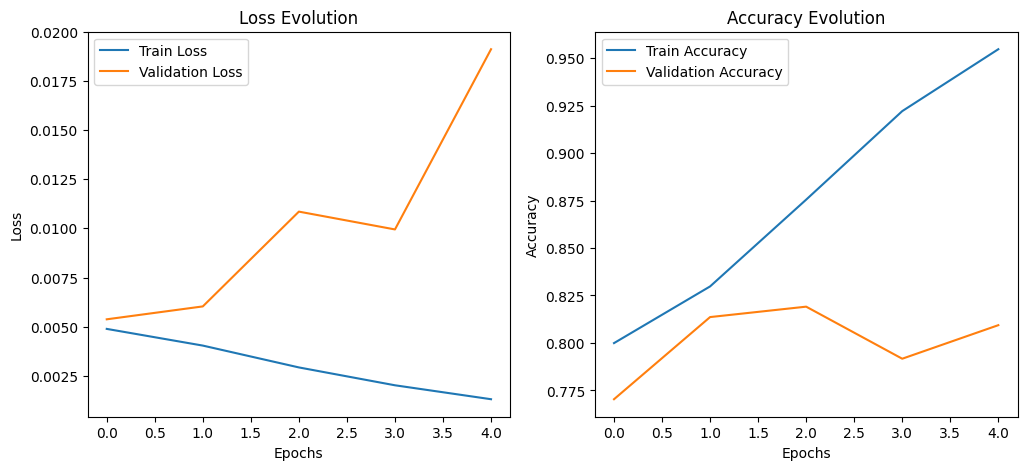

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8094 Precision: 0.4138 Recall: 0.0390 F1: 0.3372 ROC: 0.5131
---------- Fold: 2 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=88.6, loss=0.00388]


Training metrics for Epoch 1:
Accuracy: 0.8858099878197321
ROC: 0.761514312331704
Precision: 0.7676991150442478
Recall: 0.5623987034035657
F1 score: 0.6492048643592143
Train loss: 0.0039
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.78batch/s, accuracy=86.8, loss=0.00445]


Validation metrics for Epoch 1:
Accuracy: 0.8684531059683313
ROC: 0.6579436121166214
Precision: 0.9428571428571428
Recall: 0.32038834951456313
F1 score: 0.47826086956521746
Validation Loss: 0.0044
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.32      0.48       309
   No Cancer       0.86      1.00      0.92      1333

    accuracy                           0.87      1642
   macro avg       0.90      0.66      0.70      1642
weighted avg       0.88      0.87      0.84      1642



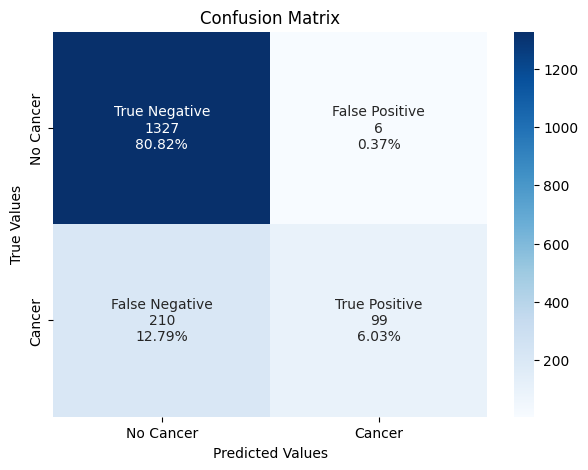

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=92.2, loss=0.00216]


Training metrics for Epoch 2:
Accuracy: 0.9220462850182704
ROC: 0.8211977959805269
Precision: 0.8984547461368654
Recall: 0.6596434359805511
F1 score: 0.7607476635514019
Train loss: 0.0022
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=90.5, loss=0.0025] 


Validation metrics for Epoch 2:
Accuracy: 0.904993909866017
ROC: 0.7513019031456893
Precision: 0.9811320754716981
Recall: 0.5048543689320388
F1 score: 0.6666666666666666
Validation Loss: 0.0025
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.50      0.67       309
   No Cancer       0.90      1.00      0.94      1333

    accuracy                           0.90      1642
   macro avg       0.94      0.75      0.81      1642
weighted avg       0.91      0.90      0.89      1642



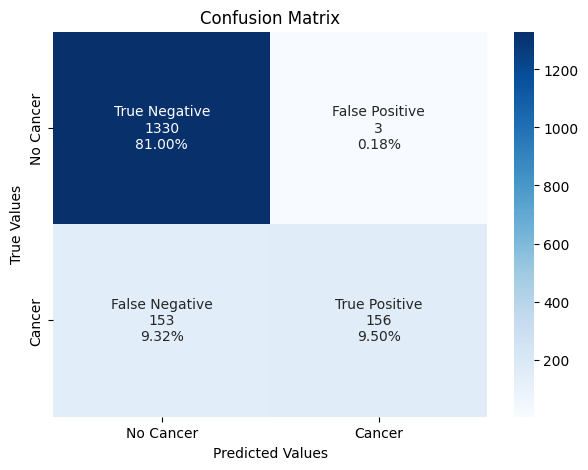

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=94.6, loss=0.00151]


Training metrics for Epoch 3:
Accuracy: 0.9464068209500609
ROC: 0.8773070708138792
Precision: 0.9366336633663367
Recall: 0.766612641815235
F1 score: 0.8431372549019609
Train loss: 0.0015
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.62batch/s, accuracy=92.4, loss=0.00204]


Validation metrics for Epoch 3:
Accuracy: 0.9238733252131547
ROC: 0.8014637154434241
Precision: 0.9842105263157894
Recall: 0.6051779935275081
F1 score: 0.7494989979959921
Validation Loss: 0.0020
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.61      0.75       309
   No Cancer       0.92      1.00      0.96      1333

    accuracy                           0.92      1642
   macro avg       0.95      0.80      0.85      1642
weighted avg       0.93      0.92      0.92      1642



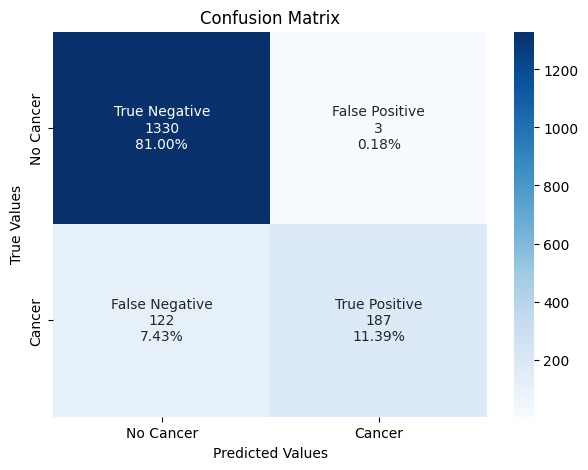

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Current Learning Rate: 1e-05
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96.2, loss=0.00115]


Training metrics for Epoch 4:
Accuracy: 0.9622411693057247
ROC: 0.9157090776942994
Precision: 0.9522935779816514
Recall: 0.8411669367909238
F1 score: 0.8932874354561101
Train loss: 0.0011
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=93.3, loss=0.00181]


Validation metrics for Epoch 4:
Accuracy: 0.9330085261875761
ROC: 0.8244925308997153
Precision: 0.9901477832512315
Recall: 0.6504854368932039
F1 score: 0.7851562500000001
Validation Loss: 0.0018
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.65      0.79       309
   No Cancer       0.92      1.00      0.96      1333

    accuracy                           0.93      1642
   macro avg       0.96      0.82      0.87      1642
weighted avg       0.94      0.93      0.93      1642



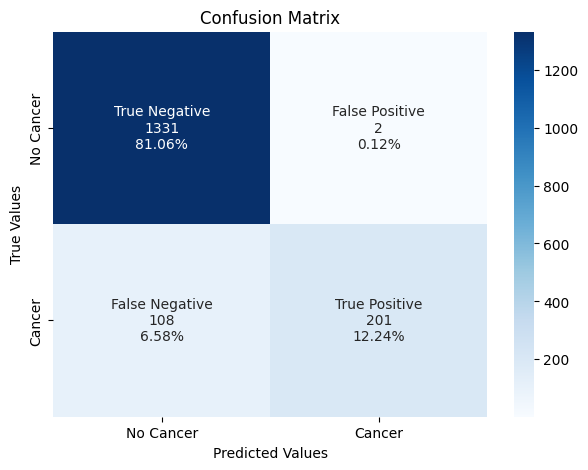

Current Learning Rate: 1e-05
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96.4, loss=0.00113]


Training metrics for Epoch 5:
Accuracy: 0.9643727161997564
ROC: 0.9151527250341682
Precision: 0.9699248120300752
Recall: 0.8363047001620746
F1 score: 0.8981723237597912
Train loss: 0.0011
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.83batch/s, accuracy=93.9, loss=0.00166]


Validation metrics for Epoch 5:
Accuracy: 0.9390986601705238
ROC: 0.840673760673178
Precision: 0.9906103286384976
Recall: 0.6828478964401294
F1 score: 0.8084291187739464
Validation Loss: 0.0017
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.68      0.81       309
   No Cancer       0.93      1.00      0.96      1333

    accuracy                           0.94      1642
   macro avg       0.96      0.84      0.89      1642
weighted avg       0.94      0.94      0.93      1642



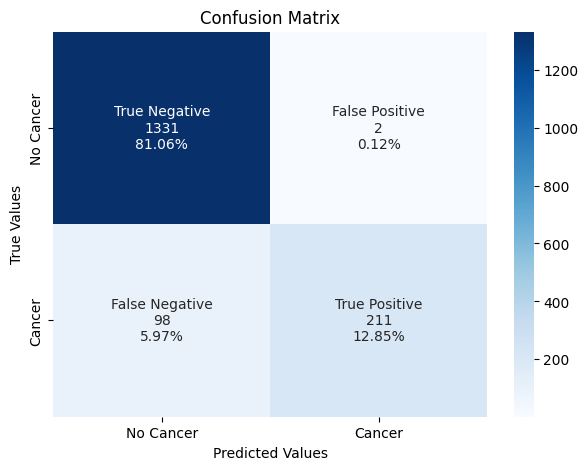

Current Learning Rate: 1e-05
Finished Training


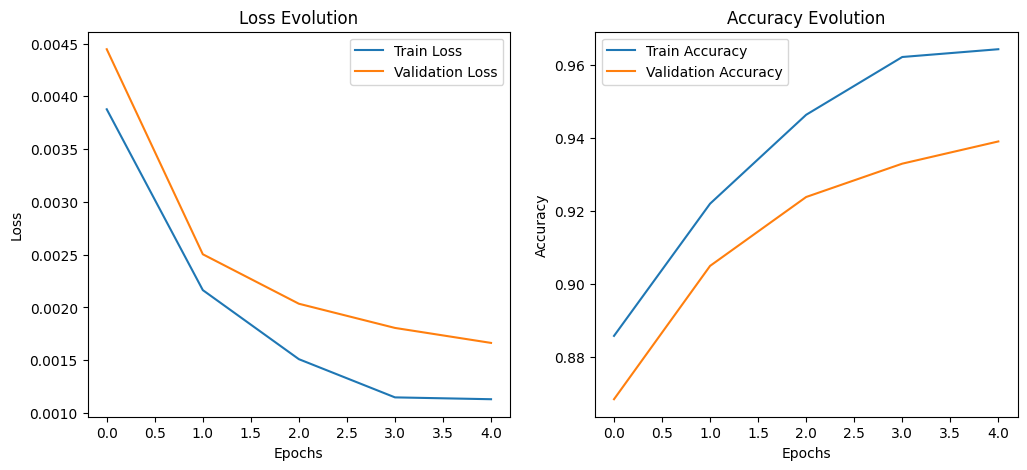

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9391 Precision: 0.9906 Recall: 0.6828 F1: 0.8084 ROC: 0.8407
---------- Fold: 3 ----------
Dimensions of train_data: (3284, 9)
Dimensions of valid_data: (1642, 9)
Class Cancer: Training instances - 617, Validation instances - 309
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=95.2, loss=0.00131]


Training metrics for Epoch 1:
Accuracy: 0.9521924482338612
ROC: 0.8945728420900385
Precision: 0.9339622641509434
Recall: 0.8022690437601296
F1 score: 0.8631211857018307
Train loss: 0.0013
Validating the trained model's performance


Validation 1: 100%|██████████| 17/17 [00:03<00:00,  4.67batch/s, accuracy=95.4, loss=0.00123]


Validation metrics for Epoch 1:
Accuracy: 0.9543239951278928
ROC: 0.8836128935146408
Precision: 0.9834710743801653
Recall: 0.7702265372168284
F1 score: 0.8638838475499092
Validation Loss: 0.0012
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.77      0.86       309
   No Cancer       0.95      1.00      0.97      1333

    accuracy                           0.95      1642
   macro avg       0.97      0.88      0.92      1642
weighted avg       0.96      0.95      0.95      1642



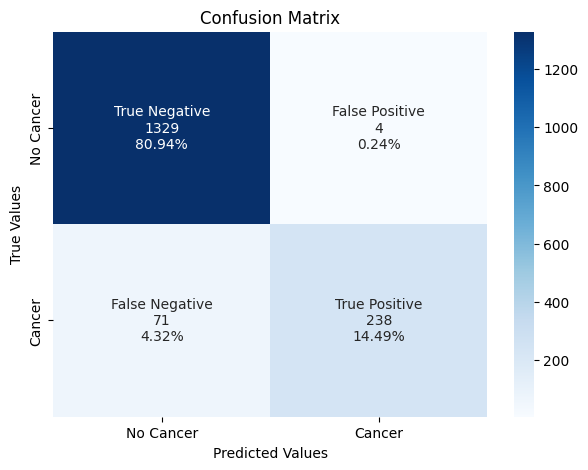

Epoch 00011: reducing learning rate of group 0 to 1.0000e-06.
Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 2, Training: 100%|██████████| 33/33 [00:21<00:00,  1.52batch/s, accuracy=96, loss=0.00118]  


Training metrics for Epoch 2:
Accuracy: 0.9604141291108405
ROC: 0.908355256241268
Precision: 0.9585687382297552
Recall: 0.8249594813614263
F1 score: 0.8867595818815331
Train loss: 0.0012
Validating the trained model's performance


Validation 2: 100%|██████████| 17/17 [00:03<00:00,  4.73batch/s, accuracy=95.8, loss=0.0011] 


Validation metrics for Epoch 2:
Accuracy: 0.9579780755176613
ROC: 0.8933216313787185
Precision: 0.9838709677419355
Recall: 0.7896440129449838
F1 score: 0.8761220825852782
Validation Loss: 0.0011
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.79      0.88       309
   No Cancer       0.95      1.00      0.97      1333

    accuracy                           0.96      1642
   macro avg       0.97      0.89      0.93      1642
weighted avg       0.96      0.96      0.96      1642



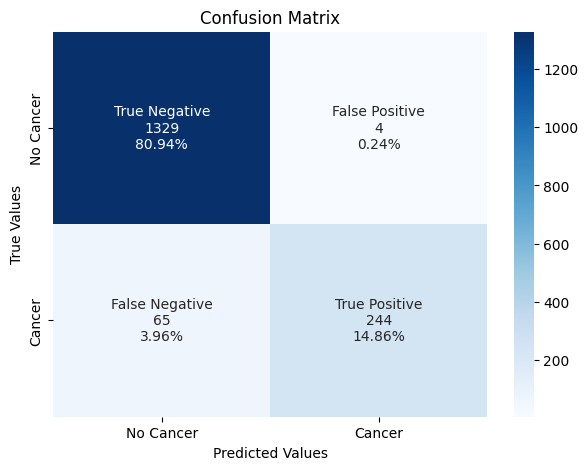

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 3, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.3, loss=0.00117]


Training metrics for Epoch 3:
Accuracy: 0.9634591961023142
ROC: 0.9177047763681081
Precision: 0.9559633027522936
Recall: 0.8444084278768234
F1 score: 0.8967297762478486
Train loss: 0.0012
Validating the trained model's performance


Validation 3: 100%|██████████| 17/17 [00:03<00:00,  4.82batch/s, accuracy=96.2, loss=0.000984]


Validation metrics for Epoch 3:
Accuracy: 0.9622411693057247
ROC: 0.9046484922201424
Precision: 0.984313725490196
Recall: 0.8122977346278317
F1 score: 0.8900709219858157
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.81      0.89       309
   No Cancer       0.96      1.00      0.98      1333

    accuracy                           0.96      1642
   macro avg       0.97      0.90      0.93      1642
weighted avg       0.96      0.96      0.96      1642



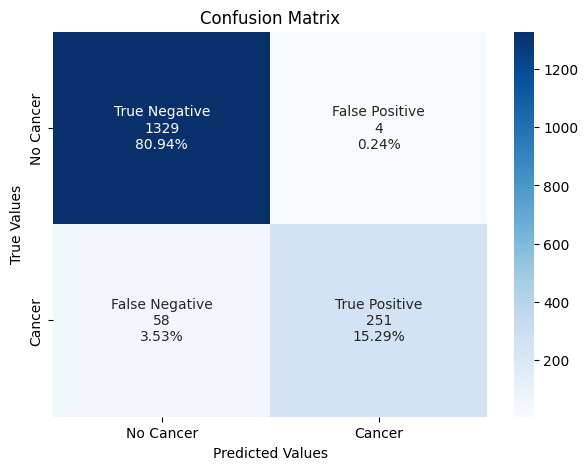

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 4, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.3, loss=0.00115]


Training metrics for Epoch 4:
Accuracy: 0.9631546894031668
ROC: 0.9200088846268609
Precision: 0.9476534296028881
Recall: 0.8508914100486223
F1 score: 0.8966695132365499
Train loss: 0.0012
Validating the trained model's performance


Validation 4: 100%|██████████| 17/17 [00:03<00:00,  4.76batch/s, accuracy=96.7, loss=0.000876]


Validation metrics for Epoch 4:
Accuracy: 0.9671132764920828
ROC: 0.9163504468350098
Precision: 0.9885057471264368
Recall: 0.8349514563106796
F1 score: 0.9052631578947368
Validation Loss: 0.0009
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.83      0.91       309
   No Cancer       0.96      1.00      0.98      1333

    accuracy                           0.97      1642
   macro avg       0.98      0.92      0.94      1642
weighted avg       0.97      0.97      0.97      1642



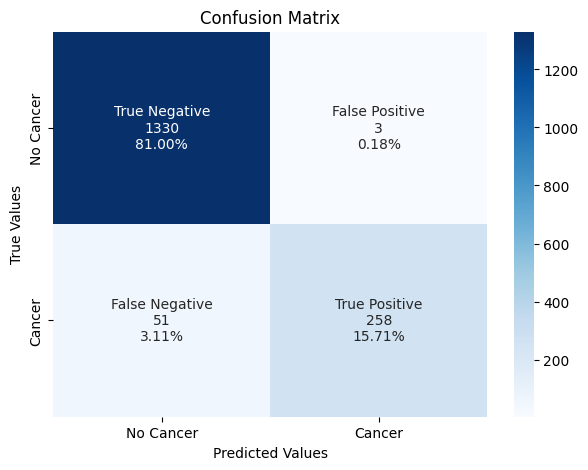

Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.
Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 5, Training: 100%|██████████| 33/33 [00:21<00:00,  1.51batch/s, accuracy=96.1, loss=0.00112]


Training metrics for Epoch 5:
Accuracy: 0.9610231425091352
ROC: 0.9137133790204911
Precision: 0.9486238532110092
Recall: 0.8379254457050244
F1 score: 0.8898450946643718
Train loss: 0.0011
Validating the trained model's performance


Validation 5: 100%|██████████| 17/17 [00:03<00:00,  4.49batch/s, accuracy=97.2, loss=0.000792]


Validation metrics for Epoch 5:
Accuracy: 0.9719853836784409
ROC: 0.928052401449877
Precision: 0.9925093632958801
Recall: 0.8576051779935275
F1 score: 0.920138888888889
Validation Loss: 0.0008
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.86      0.92       309
   No Cancer       0.97      1.00      0.98      1333

    accuracy                           0.97      1642
   macro avg       0.98      0.93      0.95      1642
weighted avg       0.97      0.97      0.97      1642



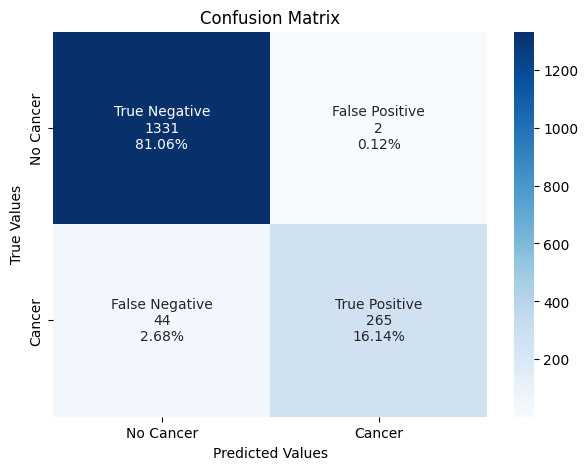

Current Learning Rate: 1.0000000000000002e-07
Finished Training


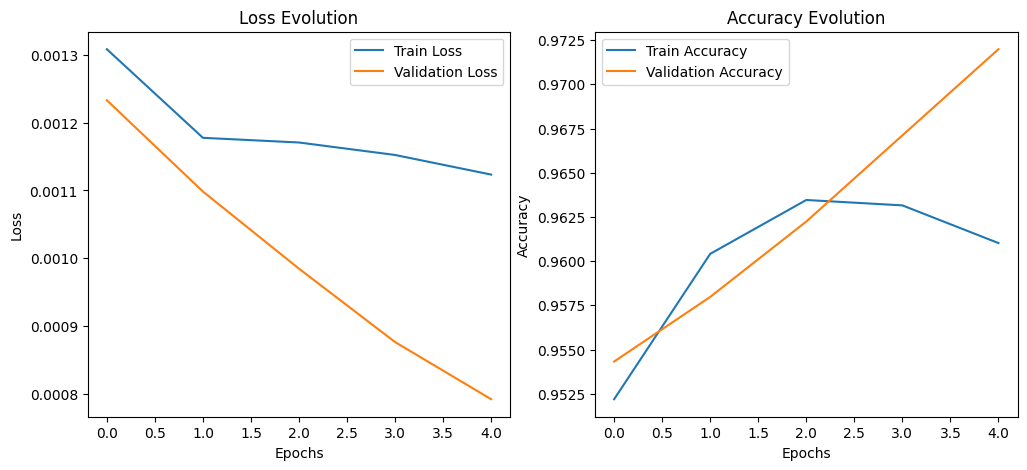

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9720 Precision: 0.9925 Recall: 0.8576 F1: 0.9201 ROC: 0.9281
The overall best model has been saved with metrics - Val Acc: 0.9720, Precision: 0.9925, Recall: 0.8576, F1: 0.9201, ROC: 0.9281
Log file at /kaggle/working/Logs/logs_2.0.0.txt has been closed.


In [43]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 100,  # Taille du batch pour la validation
    "train_batch_size": 100,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '2.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,train_data,hyperparameters)

##### Test The Best Model

Shape Of Train Sample: (1232, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,35054,387610162,1,1,63.0,0,0,No Cancer,/kaggle/working/Processed Image/35054/38761016...
1,39613,624810260,1,1,54.0,0,0,No Cancer,/kaggle/working/Processed Image/39613/62481026...
2,42214,1530070466,1,5,71.0,0,0,No Cancer,/kaggle/working/Processed Image/42214/15300704...
3,37590,567820212,1,1,54.0,0,0,No Cancer,/kaggle/working/Processed Image/37590/56782021...
4,63976,1245634911,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/63976/12456349...


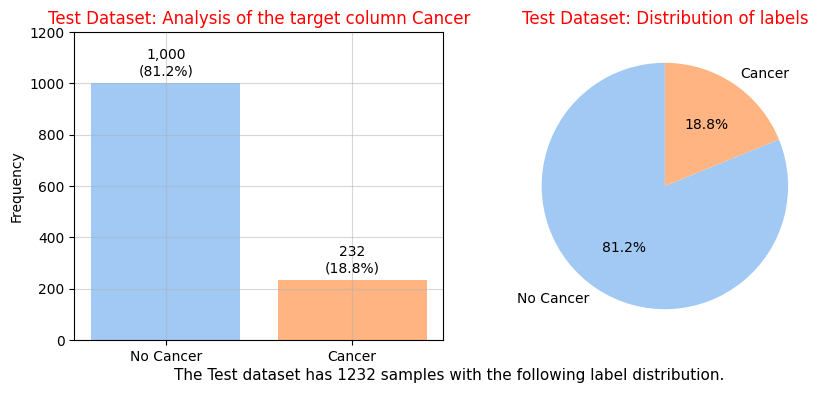

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 42/42 [00:02<00:00, 14.52batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.45      0.12      0.20       232
   No Cancer       0.83      0.96      0.89      1000

    accuracy                           0.81      1232
   macro avg       0.64      0.54      0.54      1232
weighted avg       0.75      0.81      0.76      1232



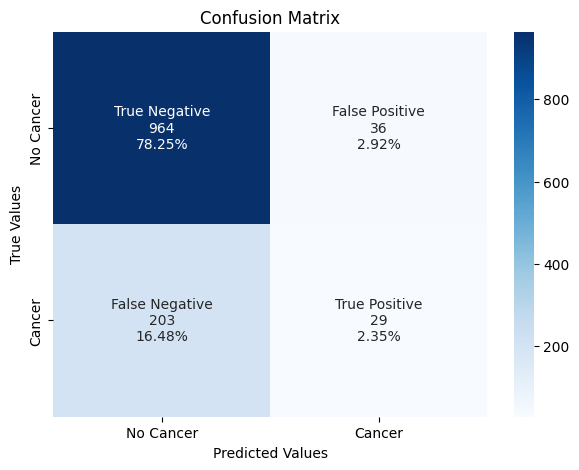

In [44]:
print(f'Shape Of Train Sample: {test_data.shape}') #test_data
display(test_data.head())
print("======="*25)
plot_label_distribution(test_data,'Test')
print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3
data_test = test_data.copy()
data_test = test_data.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(data_test,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

######################################################           Model 3          ############################################################################# 

Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


100%|██████████| 4926/4926 [00:34<00:00, 141.80it/s]


Images rejectd: 0
Images accepted: 4926
Images generated for cancer class: 4630
Images generated for no cancer class: 4000


,patient_id,image_id,image_processed_id,laterality,view,age,cancer,labels,implant,path_img_aug
0,61227,1640910603,1640910603_resized,1,1,52.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
1,13756,1628769232,1628769232_resized,1,1,71.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
2,2266,329697695,329697695_resized,1,1,64.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
3,17679,664449220,664449220_resized,1,1,68.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
4,56308,1609200371,1609200371_resized,0,5,60.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
...,...,...,...,...,...,...,...,...,...,...
8625,62996,1386866094,1386866094_resized,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
8626,62996,1386866094,1386866094_aug_0,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
8627,62996,1386866094,1386866094_aug_1,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
8628,62996,1386866094,1386866094_aug_2,0,5,67.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...


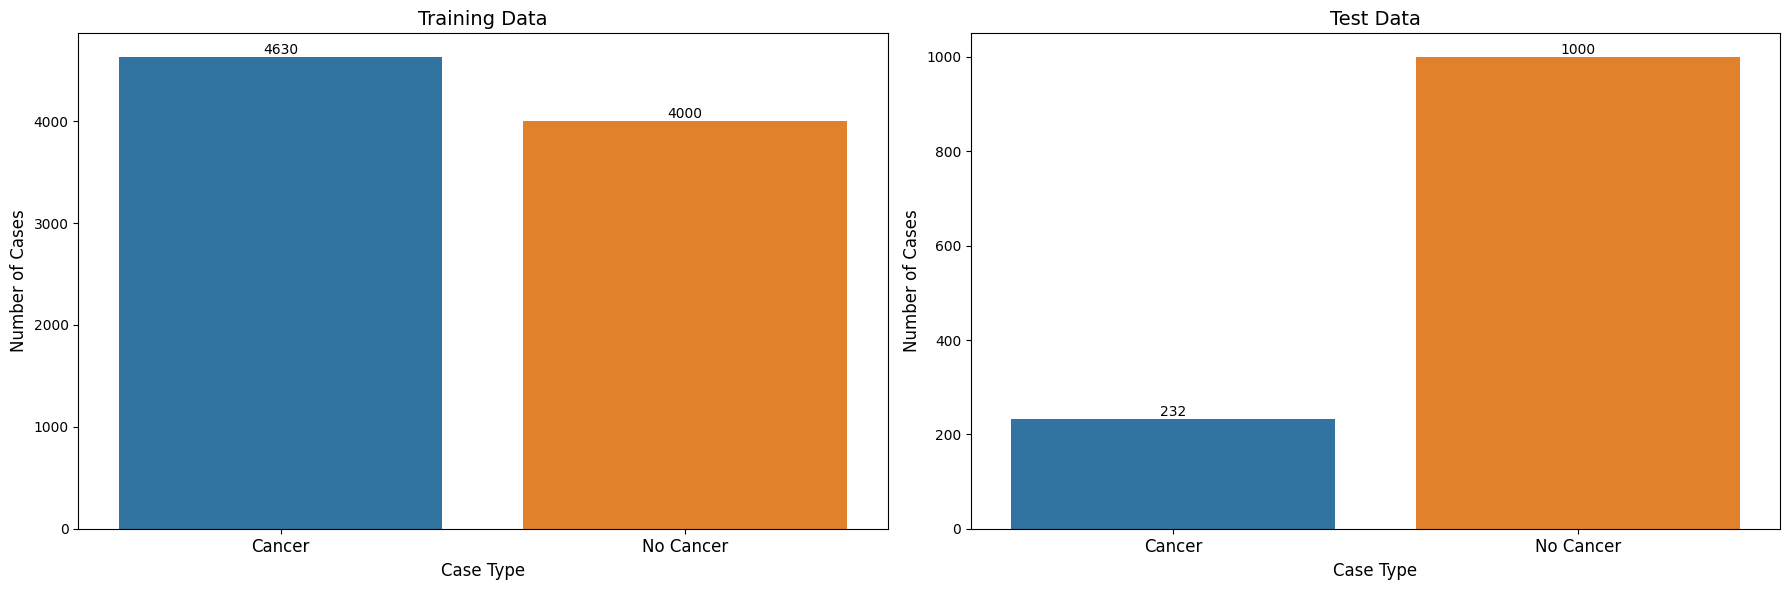

In [32]:
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

Width, Height = 224, 224

# Define simple transformations for testing
transformations_cancer = [
    A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89), A.RandomRotate90(p=1), A.Transpose(p=1)]),
    A.Compose([A.Resize(Width, Height), A.Rotate(limit=90, p=0.8), A.Perspective(scale=(0.05, 0.1), p=0.5)]),
    A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5), A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)]),
    A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89)]),
    #A.Compose([A.RandomCrop(width=200, height=200),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2),A.Resize(Width, Height)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.3), A.Transpose(p=0.8)]),
    #A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    #A.Compose([A.Resize(Width, Height), A.RandomCrop(height=200, width=200, p=0.5), A.Resize(Width, Height, p=1.0)]),
    #A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    #A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    #A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    #A.Compose([A.RandomCrop(width=150, height=200),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3),A.Resize(Width, Height)])
]

# Test the function
processed_df = apply_transformations_and_save(
    '/kaggle/working/data_augmentation_image/cancer',
    '/kaggle/working/data_augmentation_image/no_cancer',
    Width=Width, 
    Height=Height, 
    num_images_cancer=len(transformations_cancer), 
    dataset=train_data, 
    transformations_cancer=transformations_cancer)

# Display the processed DataFrame
display(processed_df)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(processed_df, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

Shape Of Train Sample: (8000, 10)


,patient_id,image_id,image_processed_id,laterality,view,age,cancer,labels,implant,path_img_aug
0,56218,1559231012,1559231012_resized,0,5,56.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
1,7279,180495029,180495029_resized,0,1,67.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
2,11087,1405254412,1405254412_resized,0,5,60.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
3,25576,1685052362,1685052362_resized,0,5,69.0,0,No Cancer,0,/kaggle/working/data_augmentation_image/no_can...
4,32057,147064371,147064371_aug_2,1,1,55.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...


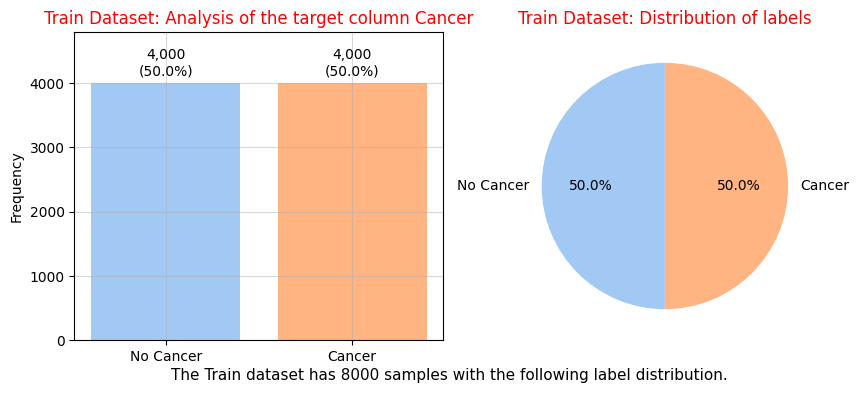

In [87]:
# Sample down for dev
num_class_0,num_class_1 =4000,4000 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(processed_df, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)
plot_label_distribution(sample_train,'Train')

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (5333, 10)
Dimensions of valid_data: (2667, 10)
Class Cancer: Training instances - 2667, Validation instances - 1333
Class No Cancer: Training instances - 2666, Validation instances - 1334
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:34<00:00,  1.54batch/s, accuracy=78.2, loss=0.00453]


Training metrics for Epoch 1:
Accuracy: 0.7824864054003375
ROC: 0.7825013058663991
Precision: 0.8359340169415961
Recall: 0.703037120359955
F1 score: 0.7637474541751527
Train loss: 0.0045
Validating the trained model's performance


Validation 1: 100%|██████████| 27/27 [00:05<00:00,  5.10batch/s, accuracy=69.3, loss=0.0161]


Validation metrics for Epoch 1:
Accuracy: 0.692538432695913
ROC: 0.6924239493156649
Precision: 0.9942196531791907
Recall: 0.3870967741935484
F1 score: 0.5572354211663068
Validation Loss: 0.0161
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.39      0.56      1333
   No Cancer       0.62      1.00      0.76      1334

    accuracy                           0.69      2667
   macro avg       0.81      0.69      0.66      2667
weighted avg       0.81      0.69      0.66      2667



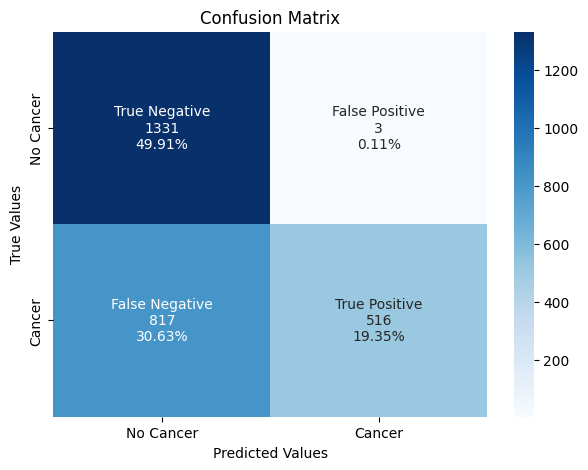

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:34<00:00,  1.54batch/s, accuracy=85.7, loss=0.00327]


Training metrics for Epoch 2:
Accuracy: 0.8565535345959122
ROC: 0.8565679805778216
Precision: 0.9215425531914894
Recall: 0.7795275590551181
F1 score: 0.8446069469835467
Train loss: 0.0033
Validating the trained model's performance


Validation 2: 100%|██████████| 27/27 [00:05<00:00,  5.03batch/s, accuracy=77.9, loss=0.00476]


Validation metrics for Epoch 2:
Accuracy: 0.7787776527934008
ROC: 0.7787807146689222
Precision: 0.7741697416974169
Recall: 0.786946736684171
F1 score: 0.7805059523809524
Validation Loss: 0.0048
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.77      0.79      0.78      1333
   No Cancer       0.78      0.77      0.78      1334

    accuracy                           0.78      2667
   macro avg       0.78      0.78      0.78      2667
weighted avg       0.78      0.78      0.78      2667



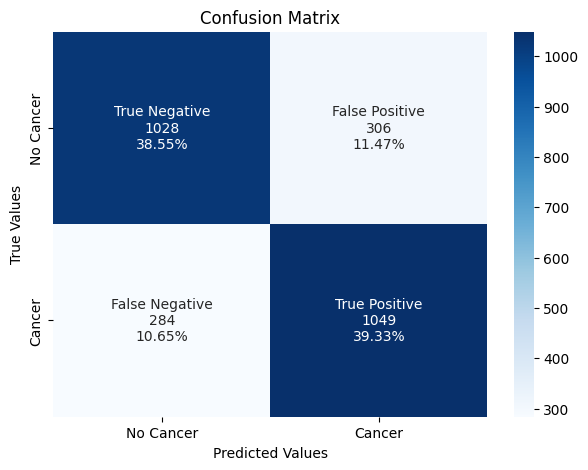

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=89.5, loss=0.00248]


Training metrics for Epoch 3:
Accuracy: 0.8946184136508532
ROC: 0.8946250201470501
Precision: 0.9245663574021783
Recall: 0.859392575928009
F1 score: 0.8907889623008162
Train loss: 0.0025
Validating the trained model's performance


Validation 3: 100%|██████████| 27/27 [00:05<00:00,  5.01batch/s, accuracy=79, loss=0.00927]  


Validation metrics for Epoch 3:
Accuracy: 0.7904011998500188
ROC: 0.7903270795210047
Precision: 0.9801488833746899
Recall: 0.5926481620405101
F1 score: 0.7386629266012155
Validation Loss: 0.0093
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.59      0.74      1333
   No Cancer       0.71      0.99      0.83      1334

    accuracy                           0.79      2667
   macro avg       0.84      0.79      0.78      2667
weighted avg       0.84      0.79      0.78      2667



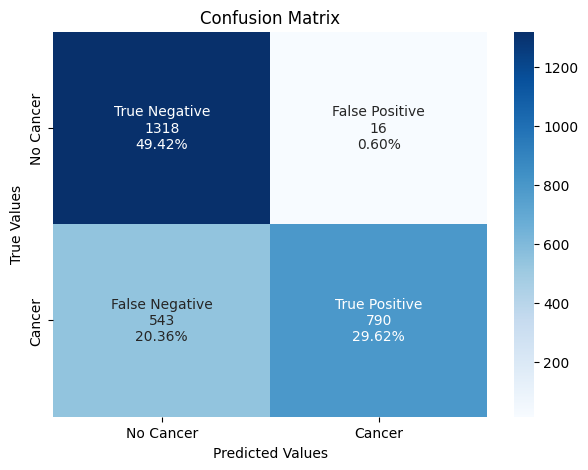

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=93.2, loss=0.00178]


Training metrics for Epoch 4:
Accuracy: 0.9324957809863117
ROC: 0.9324983101793446
Precision: 0.9445086705202312
Recall: 0.9190101237345332
F1 score: 0.9315849486887116
Train loss: 0.0018
Validating the trained model's performance


Validation 4: 100%|██████████| 27/27 [00:05<00:00,  5.13batch/s, accuracy=70.2, loss=0.0092] 


Validation metrics for Epoch 4:
Accuracy: 0.7019122609673791
ROC: 0.7019626908226306
Precision: 0.6589834515366431
Recall: 0.8364591147786947
F1 score: 0.737190082644628
Validation Loss: 0.0092
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.66      0.84      0.74      1333
   No Cancer       0.78      0.57      0.66      1334

    accuracy                           0.70      2667
   macro avg       0.72      0.70      0.70      2667
weighted avg       0.72      0.70      0.70      2667



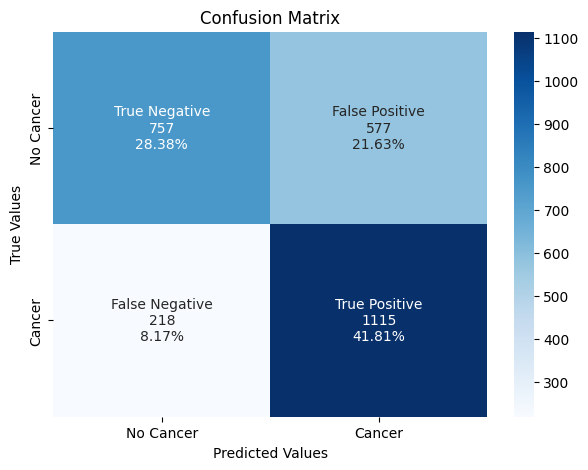

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.4, loss=0.000838]


Training metrics for Epoch 5:
Accuracy: 0.9741233827114195
ROC: 0.9741247179061356
Precision: 0.9809813617344998
Recall: 0.9670041244844394
F1 score: 0.9739425981873111
Train loss: 0.0008
Validating the trained model's performance


Validation 5: 100%|██████████| 27/27 [00:05<00:00,  5.13batch/s, accuracy=79.6, loss=0.00594]


Validation metrics for Epoch 5:
Accuracy: 0.7956505436820397
ROC: 0.7956579662156918
Precision: 0.7842712842712842
Recall: 0.8154538634658665
F1 score: 0.7995586612725266
Validation Loss: 0.0059
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.78      0.82      0.80      1333
   No Cancer       0.81      0.78      0.79      1334

    accuracy                           0.80      2667
   macro avg       0.80      0.80      0.80      2667
weighted avg       0.80      0.80      0.80      2667



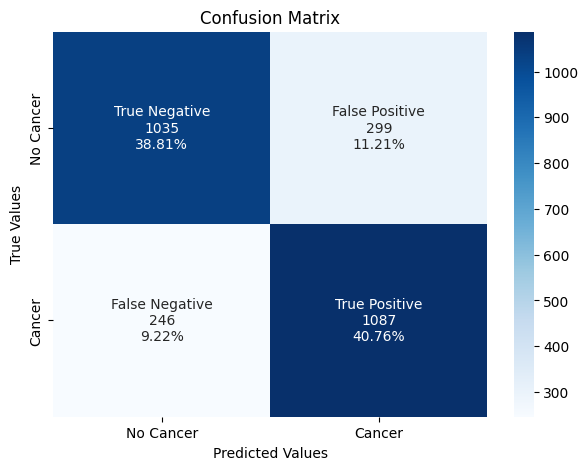

Current Learning Rate: 0.0001
Finished Training


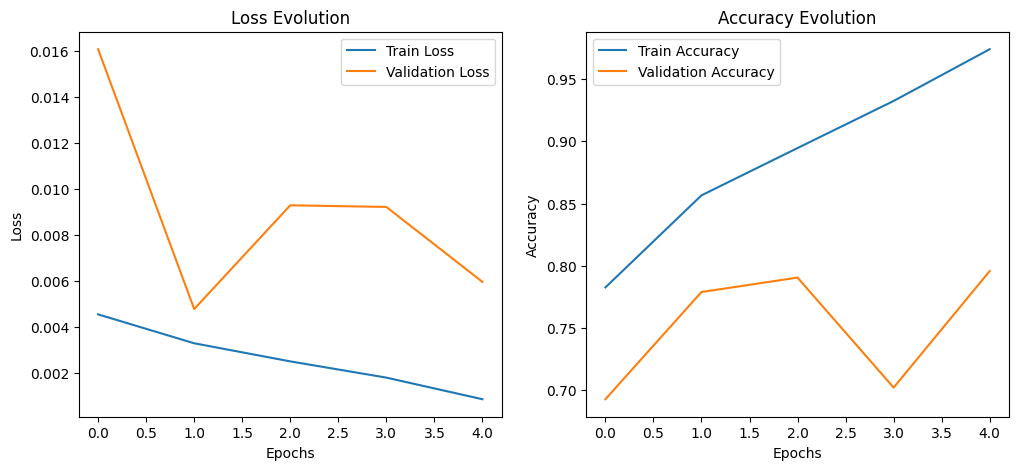

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.7957 Precision: 0.7843 Recall: 0.8155 F1: 0.7996 ROC: 0.7957
---------- Fold: 2 ----------
Dimensions of train_data: (5333, 10)
Dimensions of valid_data: (2667, 10)
Class Cancer: Training instances - 2666, Validation instances - 1334
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=92.5, loss=0.0021] 


Training metrics for Epoch 1:
Accuracy: 0.9251828239264954
ROC: 0.9251778636447638
Precision: 0.9489108910891089
Recall: 0.8987246811702926
F1 score: 0.9231361972644962
Train loss: 0.0021
Validating the trained model's performance


Validation 1: 100%|██████████| 27/27 [00:05<00:00,  5.10batch/s, accuracy=91.4, loss=0.00214]


Validation metrics for Epoch 1:
Accuracy: 0.9137607799025121
ROC: 0.9137385545786746
Precision: 0.8699731903485255
Recall: 0.9730134932533733
F1 score: 0.9186128803963198
Validation Loss: 0.0021
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.87      0.97      0.92      1334
   No Cancer       0.97      0.85      0.91      1333

    accuracy                           0.91      2667
   macro avg       0.92      0.91      0.91      2667
weighted avg       0.92      0.91      0.91      2667



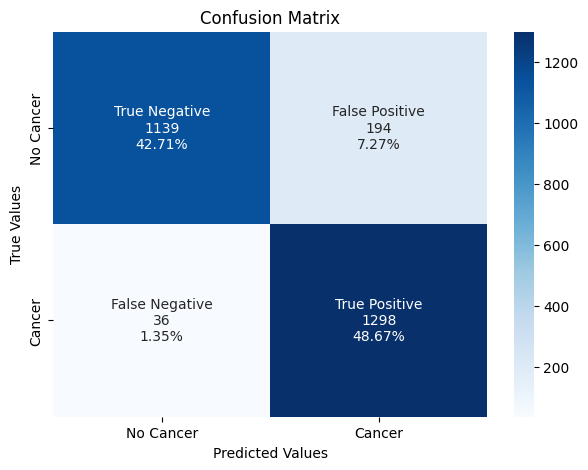

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=95.5, loss=0.00133]


Training metrics for Epoch 2:
Accuracy: 0.9546221638852428
ROC: 0.9546182946186491
Precision: 0.9741784037558685
Recall: 0.9339834958739685
F1 score: 0.953657602451168
Train loss: 0.0013
Validating the trained model's performance


Validation 2: 100%|██████████| 27/27 [00:05<00:00,  5.09batch/s, accuracy=97, loss=0.000958]  


Validation metrics for Epoch 2:
Accuracy: 0.9700037495313086
ROC: 0.970001495876218
Precision: 0.9644444444444444
Recall: 0.9760119940029985
F1 score: 0.970193740685544
Validation Loss: 0.0010
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.96      0.98      0.97      1334
   No Cancer       0.98      0.96      0.97      1333

    accuracy                           0.97      2667
   macro avg       0.97      0.97      0.97      2667
weighted avg       0.97      0.97      0.97      2667



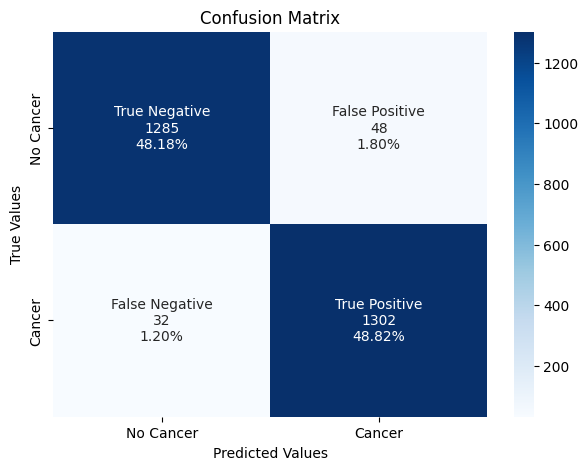

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Current Learning Rate: 1e-05
Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=96.6, loss=0.000959]


Training metrics for Epoch 3:
Accuracy: 0.9658728670541908
ROC: 0.9658701936451491
Precision: 0.9795366795366796
Recall: 0.9516129032258065
F1 score: 0.9653729071537291
Train loss: 0.0010
Validating the trained model's performance


Validation 3: 100%|██████████| 27/27 [00:05<00:00,  5.11batch/s, accuracy=97.8, loss=0.000781]


Validation metrics for Epoch 3:
Accuracy: 0.9778777652793401
ROC: 0.9778784651185286
Precision: 0.9796839729119639
Recall: 0.9760119940029985
F1 score: 0.9778445362373265
Validation Loss: 0.0008
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.98      0.98      1334
   No Cancer       0.98      0.98      0.98      1333

    accuracy                           0.98      2667
   macro avg       0.98      0.98      0.98      2667
weighted avg       0.98      0.98      0.98      2667



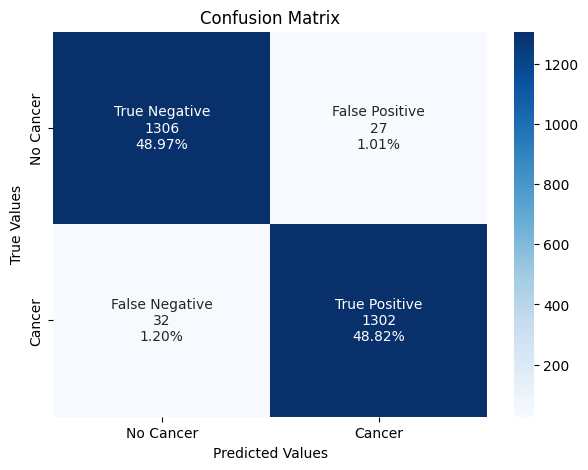

Current Learning Rate: 1e-05
Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.2, loss=0.000901]


Training metrics for Epoch 4:
Accuracy: 0.9722482655165948
ROC: 0.9722452407252544
Precision: 0.987984496124031
Recall: 0.9561140285071268
F1 score: 0.9717880289744567
Train loss: 0.0009
Validating the trained model's performance


Validation 4: 100%|██████████| 27/27 [00:05<00:00,  5.11batch/s, accuracy=98.2, loss=0.000646]


Validation metrics for Epoch 4:
Accuracy: 0.9823772028496438
ROC: 0.982379871579589
Precision: 0.9893536121673003
Recall: 0.9752623688155923
F1 score: 0.9822574556436392
Validation Loss: 0.0006
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.98      0.98      1334
   No Cancer       0.98      0.99      0.98      1333

    accuracy                           0.98      2667
   macro avg       0.98      0.98      0.98      2667
weighted avg       0.98      0.98      0.98      2667



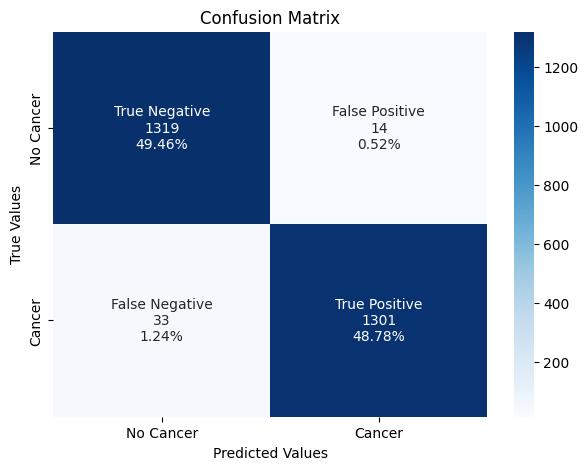

Current Learning Rate: 1e-05
Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.5, loss=0.000876]


Training metrics for Epoch 5:
Accuracy: 0.9748734295893493
ROC: 0.9748716003522816
Precision: 0.9843152257077277
Recall: 0.9651162790697675
F1 score: 0.9746212121212122
Train loss: 0.0009
Validating the trained model's performance


Validation 5: 100%|██████████| 27/27 [00:05<00:00,  4.99batch/s, accuracy=98.6, loss=0.000506]


Validation metrics for Epoch 5:
Accuracy: 0.9861267341582303
ROC: 0.9861296845950619
Precision: 0.993907083015994
Recall: 0.9782608695652174
F1 score: 0.9860219115980354
Validation Loss: 0.0005
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.98      0.99      1334
   No Cancer       0.98      0.99      0.99      1333

    accuracy                           0.99      2667
   macro avg       0.99      0.99      0.99      2667
weighted avg       0.99      0.99      0.99      2667



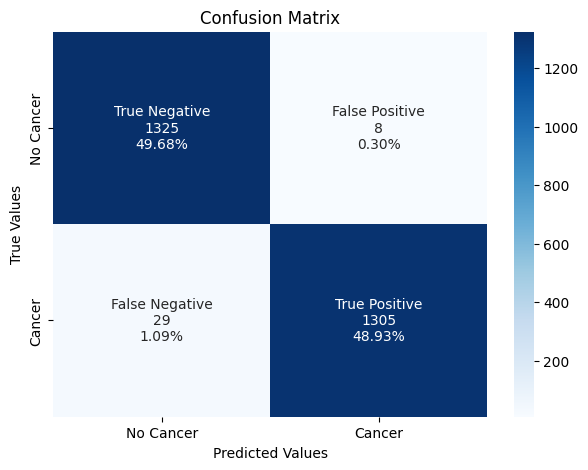

Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.
Current Learning Rate: 1.0000000000000002e-06
Finished Training


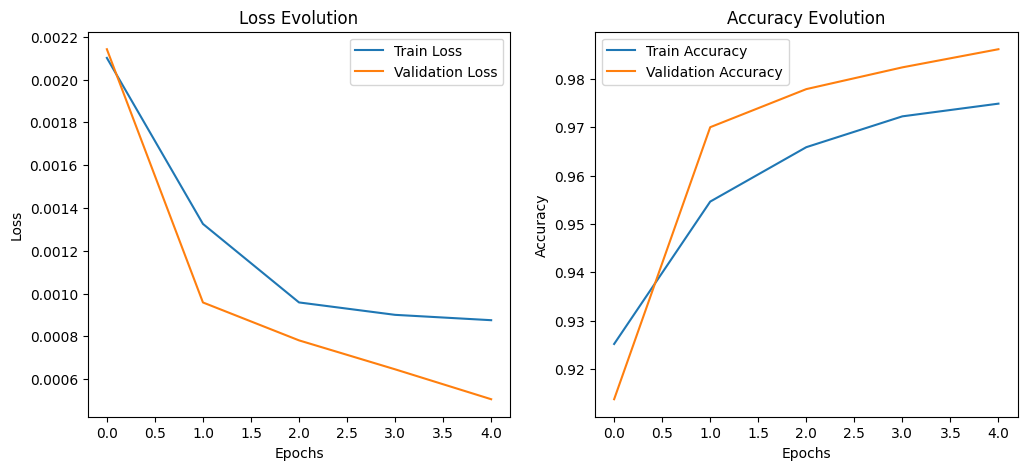

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9861 Precision: 0.9939 Recall: 0.9783 F1: 0.9860 ROC: 0.9861
---------- Fold: 3 ----------
Dimensions of train_data: (5334, 10)
Dimensions of valid_data: (2666, 10)
Class Cancer: Training instances - 2667, Validation instances - 1333
Class No Cancer: Training instances - 2667, Validation instances - 1333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.3, loss=0.000836]


Training metrics for Epoch 1:
Accuracy: 0.9728158980127484
ROC: 0.9728158980127484
Precision: 0.9846272098385856
Recall: 0.9606299212598425
F1 score: 0.9724805465932814
Train loss: 0.0008
Validating the trained model's performance


Validation 1: 100%|██████████| 27/27 [00:05<00:00,  5.08batch/s, accuracy=99.4, loss=0.000312]


Validation metrics for Epoch 1:
Accuracy: 0.9939984996249063
ROC: 0.9939984996249063
Precision: 0.9984859954579863
Recall: 0.9894973743435859
F1 score: 0.9939713639788997
Validation Loss: 0.0003
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.99      0.99      1333
   No Cancer       0.99      1.00      0.99      1333

    accuracy                           0.99      2666
   macro avg       0.99      0.99      0.99      2666
weighted avg       0.99      0.99      0.99      2666



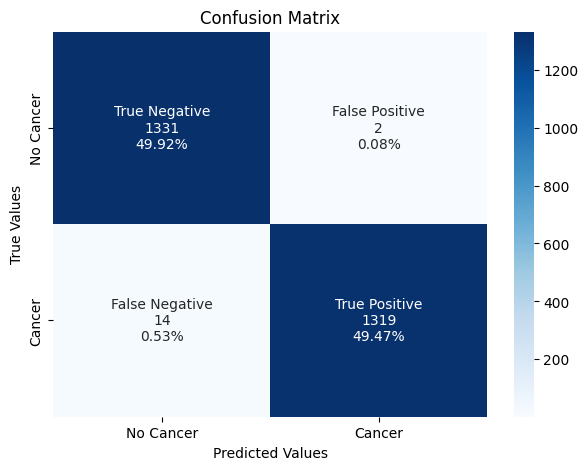

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.1, loss=0.000852]


Training metrics for Epoch 2:
Accuracy: 0.9707536557930259
ROC: 0.9707536557930259
Precision: 0.9815880322209436
Recall: 0.9595050618672666
F1 score: 0.9704209328782708
Train loss: 0.0009
Validating the trained model's performance


Validation 2: 100%|██████████| 27/27 [00:05<00:00,  5.07batch/s, accuracy=99.5, loss=0.000255]


Validation metrics for Epoch 2:
Accuracy: 0.994748687171793
ROC: 0.9947486871717931
Precision: 0.99848828420257
Recall: 0.9909977494373593
F1 score: 0.9947289156626505
Validation Loss: 0.0003
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.99      0.99      1333
   No Cancer       0.99      1.00      0.99      1333

    accuracy                           0.99      2666
   macro avg       0.99      0.99      0.99      2666
weighted avg       0.99      0.99      0.99      2666



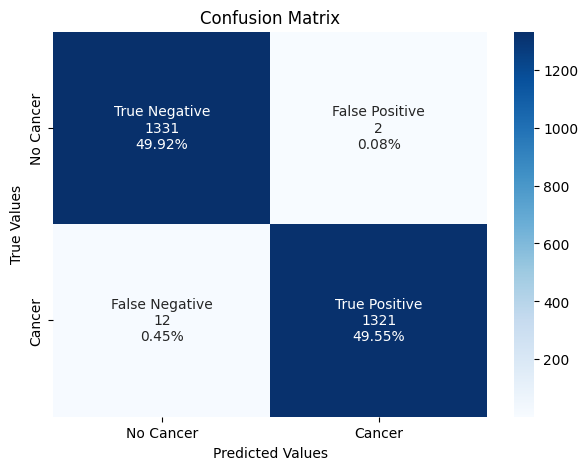

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.3, loss=0.000849]


Training metrics for Epoch 3:
Accuracy: 0.973190851143607
ROC: 0.973190851143607
Precision: 0.9850115295926211
Recall: 0.9610048743907011
F1 score: 0.9728601252609604
Train loss: 0.0008
Validating the trained model's performance


Validation 3: 100%|██████████| 27/27 [00:05<00:00,  5.00batch/s, accuracy=99.7, loss=0.000214]


Validation metrics for Epoch 3:
Accuracy: 0.9969992498124531
ROC: 0.9969992498124531
Precision: 1.0
Recall: 0.9939984996249063
F1 score: 0.9969902182091799
Validation Loss: 0.0002
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.99      1.00      1333
   No Cancer       0.99      1.00      1.00      1333

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666



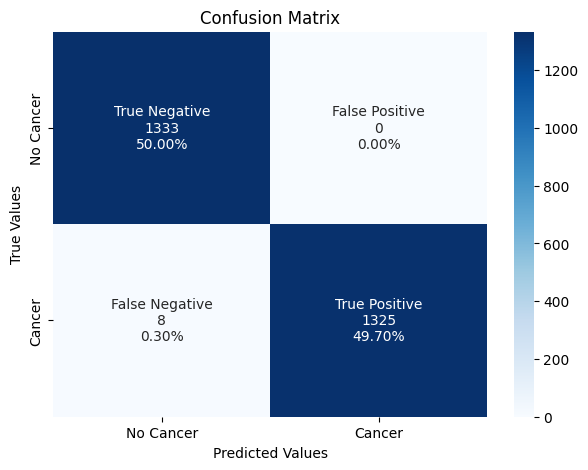

Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.
Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.3, loss=0.00083] 


Training metrics for Epoch 4:
Accuracy: 0.9730033745781778
ROC: 0.9730033745781778
Precision: 0.9850057670126874
Recall: 0.9606299212598425
F1 score: 0.9726651480637813
Train loss: 0.0008
Validating the trained model's performance


Validation 4: 100%|██████████| 27/27 [00:05<00:00,  5.04batch/s, accuracy=99.8, loss=0.000183]


Validation metrics for Epoch 4:
Accuracy: 0.9981245311327832
ROC: 0.9981245311327832
Precision: 1.0
Recall: 0.9962490622655664
F1 score: 0.9981210071401729
Validation Loss: 0.0002
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1333
   No Cancer       1.00      1.00      1.00      1333

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666



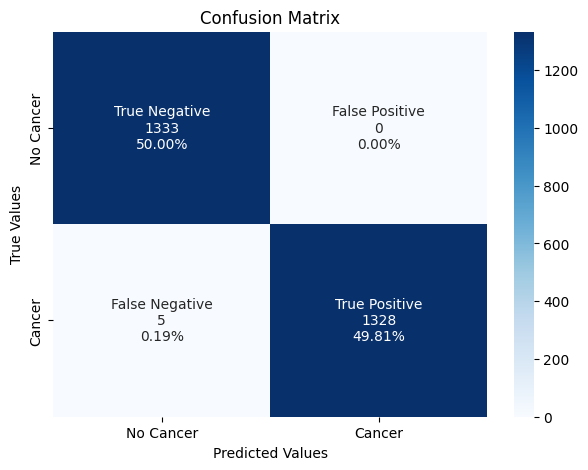

Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.54batch/s, accuracy=97.5, loss=0.000837]


Training metrics for Epoch 5:
Accuracy: 0.9752530933633295
ROC: 0.9752530933633295
Precision: 0.9873125720876585
Recall: 0.9628796400449944
F1 score: 0.9749430523917995
Train loss: 0.0008
Validating the trained model's performance


Validation 5: 100%|██████████| 27/27 [00:05<00:00,  5.08batch/s, accuracy=99.9, loss=0.000161]


Validation metrics for Epoch 5:
Accuracy: 0.9992498124531133
ROC: 0.9992498124531133
Precision: 1.0
Recall: 0.9984996249062266
F1 score: 0.9992492492492493
Validation Loss: 0.0002
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1333
   No Cancer       1.00      1.00      1.00      1333

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666



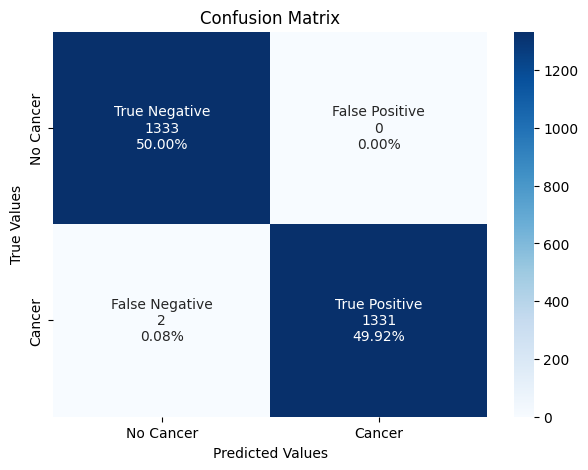

Current Learning Rate: 1.0000000000000002e-07
Finished Training


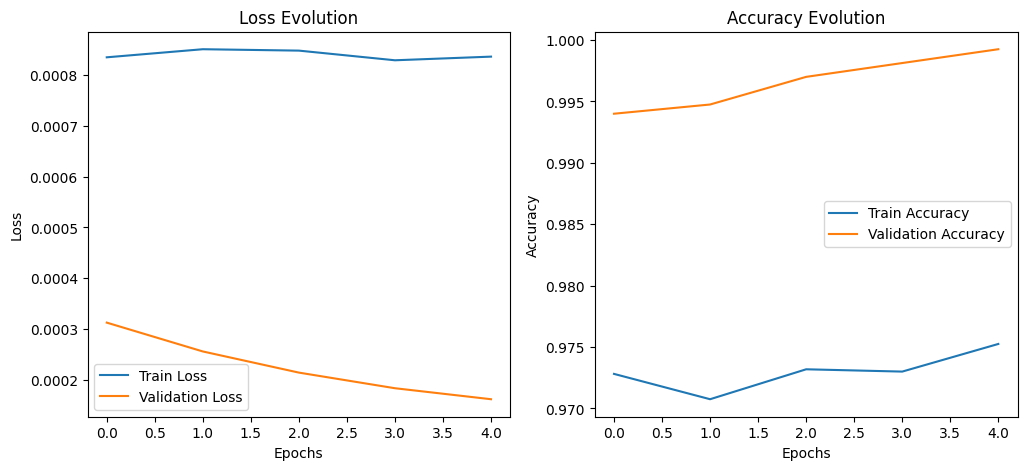

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9992 Precision: 1.0000 Recall: 0.9985 F1: 0.9992 ROC: 0.9992
The overall best model has been saved with metrics - Val Acc: 0.9992, Precision: 1.0000, Recall: 0.9985, F1: 0.9992, ROC: 0.9992


UnboundLocalError: local variable 'image' referenced before assignment

In [92]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 100,  # Taille du batch pour la validation
    "train_batch_size": 100,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 5,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '3.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,sample_train,hyperparameters)

In [97]:
class My_Custom_RSNA_Dataset(Dataset): 
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}

## Test Model 3

---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Shape Of Train Sample: (10942, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,50251,1764774515,1,1,66.0,0,0,No Cancer,/kaggle/working/Processed Image/50251/17647745...
1,17552,2020448477,0,5,77.0,0,0,No Cancer,/kaggle/working/Processed Image/17552/20204484...
2,56125,569514262,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/56125/56951426...
3,59102,1324423486,0,1,46.0,0,0,No Cancer,/kaggle/working/Processed Image/59102/13244234...
4,7420,331414632,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/7420/331414632...


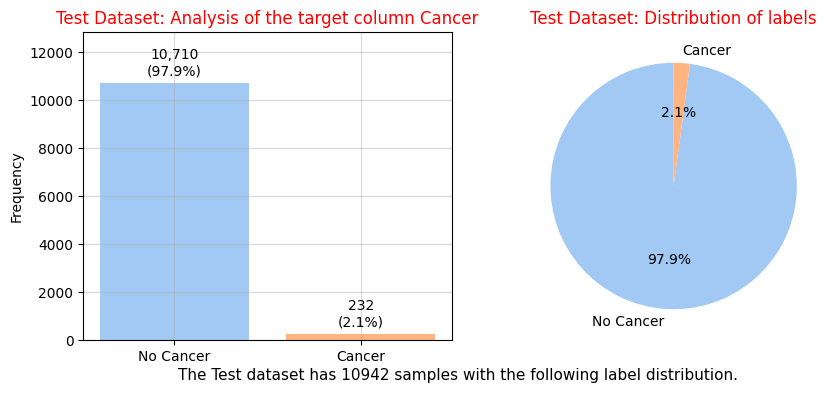

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 365/365 [00:22<00:00, 16.06batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.10      0.23      0.14       232
   No Cancer       0.98      0.95      0.97     10710

    accuracy                           0.94     10942
   macro avg       0.54      0.59      0.55     10942
weighted avg       0.96      0.94      0.95     10942



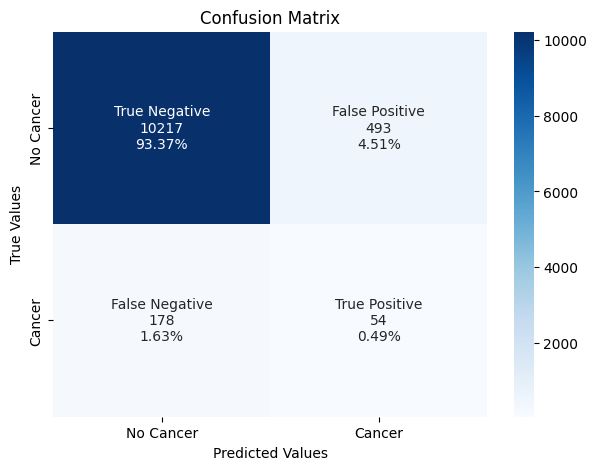

In [98]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 3 -------------------------------------------------------------------------------------" + Color.E)
print(f'Shape Of Train Sample: {test_data.shape}') #test_data test_data
display(test_data.head())
print("======="*25)
plot_label_distribution(test_data,'Test')
print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3
data_test = test_data.copy()
data_test = test_data.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(data_test,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)